In [1]:
%matplotlib widget
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats
import scipy.stats.qmc
import sys
import time
sys.path.append("/usr/wrk/people9/sima9999/code/")
sys.path.append("/vegas/users/staff/womo1998/Projects/2019_OMA_UQ/code/")
from helpers import get_pcd
from itertools import product
import pandas as pd
from matplotlib.patches import Rectangle
import seaborn as sns
import scipy.interpolate
import scipy.optimize
import ray
import matplotlib.colors
import os

{'text.usetex': True, 'text.latex.preamble': '\\usepackage{siunitx}', 'font.size': 10, 'legend.fontsize': 10, 'xtick.labelsize': 10, 'ytick.labelsize': 10, 'axes.labelsize': 10, 'font.family': 'serif', 'legend.labelspacing': 0.1, 'axes.linewidth': 0.5, 'xtick.major.width': 0.5, 'ytick.major.width': 0.5, 'figure.figsize': (5.906, 3.6501854140914705), 'figure.dpi': 100}


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
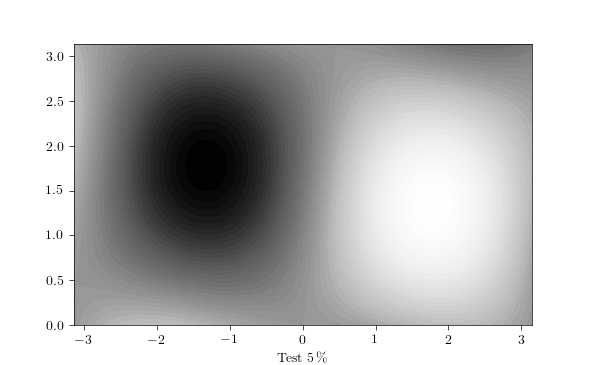

In [3]:
def himmelblau(x,y,):
    return (((x**2+y-11)**2) + (((x+y**2-7)**2)))
def rosenbrock(x,y, b=10):
    return (x-1)**2 + b*(y-x**2)**2
def sin_exmpl(x,y):
    '''
    half sine from top to bottom, full sine from left to right
    y= 0.../pi
    x=-pi,pi
    '''
    alpha=35/np.pi
    x=np.copy(x)
    y=np.copy(y)
    if isinstance(x, np.ndarray):
        for i in range(x.shape[0]):
            x[i],y[i]=np.array([[np.cos(alpha), -np.sin(alpha)],[np.sin(alpha), np.cos(alpha)]]).dot(np.array([x[i],y[i]]))
    else:
        x,y = np.array([[np.cos(alpha), -np.sin(alpha)],[np.sin(alpha), np.cos(alpha)]]).dot(np.array([x,y]))
    return np.sin(x)*np.sin(y)

#x=np.linspace(-2,3.5)
#X,Y= np.meshgrid(x,x)
#Z = himmelblau(X,Y)
# x=np.linspace(-1.5,1.5)
# y=np.linspace(-0.5,3.5)
# X,Y= np.meshgrid(x,y)
# Z = rosenbrock(X,Y)
x=np.linspace(-np.pi, np.pi,1000)
y=np.linspace(0, np.pi, 1000)
X,Y= np.meshgrid(x,y)
Z = sin_exmpl(X,Y)
pcd = get_pcd()
print(pcd)
with matplotlib.rc_context(pcd):
    fig = plt.figure()
    #ax = fig.gca(projection='3d')
    # ax.plot_surface(X,Y,Z,cmap='gist_heat_r')
    ax = fig.gca()
    ax.contourf(X,Y,Z,levels=50, cmap='Greys')
    ax.set_xlabel('Test \SI{5}{\percent}')
    # ax.plot(1,1,ls='none',marker='o')
    # ax.plot(0,3.5,ls='none',marker='o')
    plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
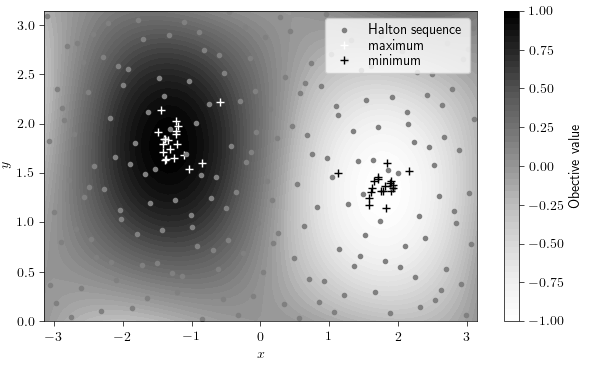

In [ ]:

with matplotlib.rc_context(rc=get_pcd()): 
    
    x=np.linspace(-np.pi, np.pi)
    y=np.linspace(0, np.pi)
    X,Y= np.meshgrid(x,y)
    Z = sin_exmpl(X,Y)
    fig=plt.figure()
    plt.contourf(X,Y,Z,levels=50, cmap='Greys', vmin=-1, vmax=1)
    ax=plt.gca()
    confidence = np.empty((12,20,2)) #2 each of: maxmc, maxqmc, minmc, minqmc, maxzqmc, minzqmc, maxzmc, minzmc
    for k in range(confidence.shape[1]):
        N_mcs=k+1
        N_mcs*=10


        maxmc = np.empty((2,30)) # 100 random trials of approximate interval optimization
        minmc, maxqmc, minqmc = np.empty_like(maxmc), np.empty_like(maxmc), np.empty_like(maxmc)
        zqmc, zmc = np.empty((2,30)), np.empty((2,30))
        
        for i in range(maxmc.shape[1]):
            engine = scipy.stats.qmc.Halton(2)
            xy = engine.random(N_mcs).T

            xy[0,:] = scipy.stats.uniform(np.min(x), np.max(x)-np.min(x)).ppf(xy[0,:])
            xy[1,:] = scipy.stats.uniform(np.min(y), np.max(y)-np.min(y)).ppf(xy[1,:])

    #         z = rosenbrock(xy[0,:],xy[1,:])
            z = sin_exmpl(xy[0,:],xy[1,:])
            maxxy = xy[:,np.argmax(z)]
            maxz = np.max(z)
            minxy = xy[:,np.argmin(z)]
            minz = np.min(z)
            maxqmc[:,i]=maxxy
            minqmc[:,i]=minxy
            zqmc[0,i] = minz
            zqmc[1,i] = maxz
            
            if k == 18 and i ==0:
                
                ax.plot(*xy, ls='none', marker='.', markerfacecolor='#808080', markeredgecolor='#808080', label='Halton sequence')
                ax.plot(*maxxy, ls='none', marker='+', color='white', label='maximum')
                ax.plot(*minxy, ls='none', marker='+', color='black', label='minimum')  
            elif i == 0:
                ax.plot(*maxxy, ls='none', marker='+', color='white')
                ax.plot(*minxy, ls='none', marker='+', color='black') 

            xy = np.random.random((N_mcs,2)).T

            xy[0,:] = scipy.stats.uniform(np.min(x), np.max(x)-np.min(x)).ppf(xy[0,:])
            xy[1,:] = scipy.stats.uniform(np.min(y), np.max(y)-np.min(y)).ppf(xy[1,:])

    #         z = rosenbrock(xy[0,:],xy[1,:])
            z = sin_exmpl(xy[0,:],xy[1,:])
            maxxy = xy[:,np.argmax(z)]
            maxz = np.max(z)
            minxy = xy[:,np.argmin(z)]
            minz = np.min(z)

            maxmc[:,i]=maxxy
            minmc[:,i]=minxy
            zmc[0,i] = minz
            zmc[1,i] = maxz

        alpha=35/np.pi

        r1,r2 = np.array([[np.cos(alpha), -np.sin(alpha)],[np.sin(alpha), np.cos(alpha)]]).dot(np.array([np.pi/2, -np.pi/2]))

        (maxmc[0,:],maxmc[1,:],minmc[0,:],minmc[1,:],maxqmc[0,:],maxqmc[1,:],minqmc[0,:],minqmc[1,:])
        for j, a in enumerate((maxmc[0,:]-r1,maxmc[1,:]+r2,minmc[0,:]+r2,minmc[1,:]+r1,
                               maxqmc[0,:]-r1,maxqmc[1,:]+r2,minqmc[0,:]+r2,minqmc[1,:]+r1),
                             ):
            a/=np.pi/2
            confidence[j,k,:] = scipy.stats.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=scipy.stats.sem(a))
            
        for j,a in [(8,zmc[0,:]),(9,zmc[1,:]),(10,zqmc[0,:]),(11,zqmc[1,:])]:
            confidence[j,k,:] = scipy.stats.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=scipy.stats.sem(a))

    cbar = plt.colorbar()
    cbar.set_label('Obective value')
    cbar.set_ticks([-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1])
    plt.clim(-1,1)
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.legend(loc='upper right')
    fig.subplots_adjust(top=0.97,bottom=0.12, left=0.075, right=0.99)
#     fig.savefig(f'/vegas/users/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/interv_opti.pdf')
#     fig.savefig(f'/vegas/users/staff/womo1998/Projects/2019_OMA_UQ/tex/figures/math_basics/interv_opti.png', dpi=300)



In [82]:
zmc[0,:]

array([-0.96906148, -0.97109732, -0.98898034, -0.98367837, -0.98970346,
       -0.96212789, -0.97578034, -0.98804203, -0.98768071, -0.99224202,
       -0.98941412, -0.98584536, -0.99430228, -0.99658064, -0.99258671,
       -0.99793813, -0.97617456, -0.98655518, -0.9470749 , -0.99297969,
       -0.98868726, -0.99642944, -0.98688448, -0.96035184, -0.99898865,
       -0.99503984, -0.99554483, -0.98106749, -0.99670416, -0.97231837])

<IPython.core.display.Javascript object>


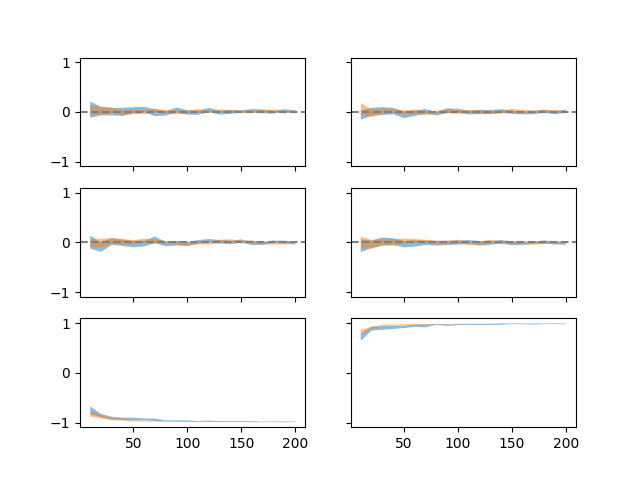

In [83]:
fig, axes = plt.subplots(3,2, sharex=True, sharey=True)
ax1,ax2,ax3,ax4, ax5, ax6 = axes.flat
N = np.arange(1,confidence.shape[1]+1)*10
ax1.axhline(0, c='grey',ls='--')
ax2.axhline(0, c='grey',ls='--')
ax3.axhline(0, c='grey',ls='--')
ax4.axhline(0, c='grey',ls='--')

ax1.fill_between(N,confidence[0,:,0],confidence[0,:,1],alpha=.5) # MCS: x_max
ax2.fill_between(N,confidence[1,:,0],confidence[1,:,1],alpha=.5) # MCS: y_max
ax3.fill_between(N,confidence[2,:,0],confidence[2,:,1],alpha=.5) # MCS: x_min
ax4.fill_between(N,confidence[3,:,0],confidence[3,:,1],alpha=.5) # MCS: y_min
ax5.fill_between(N,confidence[8,:,0],confidence[8,:,1],alpha=.5) # MCS: z_min
ax6.fill_between(N,confidence[9,:,0],confidence[9,:,1],alpha=.5) # MCS: z_max

ax1.fill_between(N,confidence[4,:,0],confidence[4,:,1],alpha=.5) # qMCS: x_max
ax2.fill_between(N,confidence[5,:,0],confidence[5,:,1],alpha=.5) # qMCS: y_max
ax3.fill_between(N,confidence[6,:,0],confidence[6,:,1],alpha=.5) # qMCS: x_min
ax4.fill_between(N,confidence[7,:,0],confidence[7,:,1],alpha=.5) # qMCS: y_min
ax5.fill_between(N,confidence[10,:,0],confidence[10,:,1],alpha=.5) # qMCS: z_min
ax6.fill_between(N,confidence[11,:,0],confidence[11,:,1],alpha=.5) # qMCS: z_max



<IPython.core.display.Javascript object>


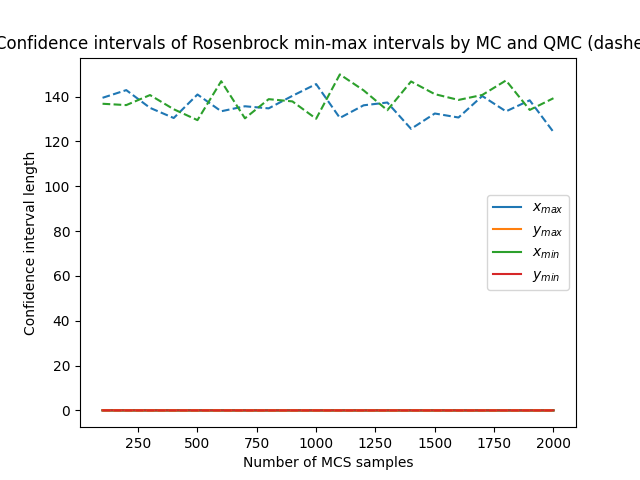

In [17]:
plt.figure()
dc = np.diff(confidence, axis=2).squeeze()

line_objs = plt.plot(x,dc[:4,:].T, )
plt.gca().set_prop_cycle(None)
plt.plot(x,dc[4:,:].T, ls='--')
plt.gca().legend(line_objs,['$x_{max}$','$y_{max}$','$x_{min}$','$y_{min}$'])
plt.ylabel("Confidence interval length")
plt.xlabel("Number of MCS samples")
plt.title("Confidence intervals of Rosenbrock min-max intervals by MC and QMC (dashed)")
plt.show()

#### approximation of CDFs by intervals and uniform sampling ####

<IPython.core.display.Javascript object>


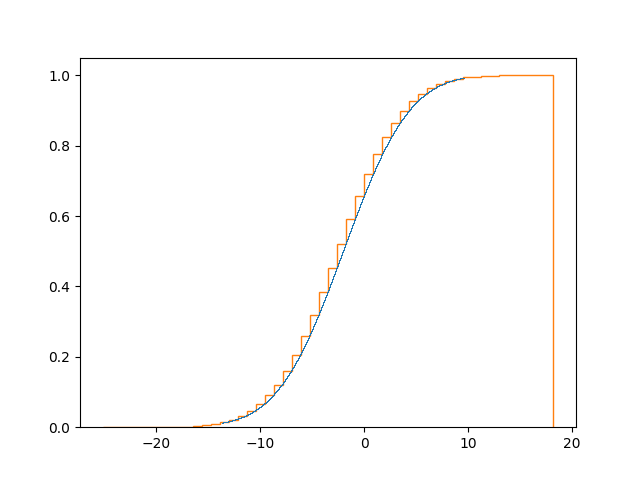

-1.9882186117506524 5.085602733629414


In [239]:
N_mcs = 100000
# normal RV with mu = -2, sigma = 5
rv = scipy.stats.norm(-2, 5)
# get support (define upper and lower bounds, e.g. 99 % quantiles, 1% quantiles)
support = rv.ppf([0.01,0.99])
# sample uniform values in support interval
rvu = scipy.stats.uniform(support[0], support[1]-support[0])
rvs = rvu.ppf(np.random.random(N_mcs))
# plot sampled values vs. their CDF
cdf = rv.cdf(rvs)
pdf = rv.pdf(rvs)
plt.figure()
plt.plot(rvs, cdf, ls='none', marker=',')
plt.hist(rv.rvs(N_mcs), bins=50, histtype='step', density=True, cumulative=True)
print(np.average(rvs, weights=pdf), np.sqrt(np.average(rvs**2, weights=pdf)))

#### comparison of standard MCS vs. QMC (uniform) sampling and product probabilities ####

In [589]:
# natural frequency of a SDOF system f = sqrt(k / m)
freq = lambda k,m: np.sqrt(k/m)
damp = lambda k,m,c: c/2/np.sqrt(m*k)
# define log normal RV k: E = 5, Var = 2 
E, Var = 5, 2
mu = np.log(E**2 / np.sqrt(Var + E**2))
s2 = np.log(Var / E**2 + 1)
rvk = scipy.stats.lognorm(np.sqrt(s2),scale = np.exp(mu))
# define /log normal RV m: E = 2, Var = 1
E, Var = 2, 1
mu = np.log(E**2 / np.sqrt(Var + E**2))
s2 = np.log(Var / E**2 + 1)
rvm = scipy.stats.lognorm(np.sqrt(s2),scale = np.exp(mu))
# define interval Variable c:  (zeta=0.001, 0.1)
ivc = [5e-1 , 1.9]
rvc = scipy.stats.uniform(ivc[0], ivc[1]-ivc[0]) # for pure aleatory Monte Carlo treat as uniform random variable

/vegas/apps/compiler/intel/intelpython3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


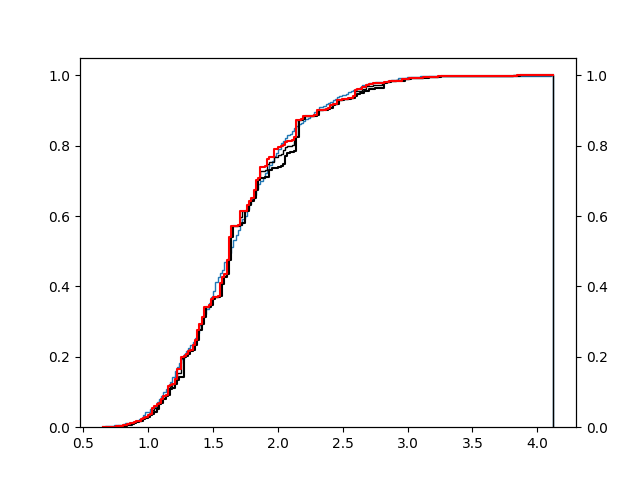

1.686737421965589 0.45958659067333896


In [487]:
N_mcs=1000
# sample N_mcs samples from both
rvks=rvk.rvs(N_mcs)
rvms=rvm.rvs(N_mcs)
# propagate through mapping function
fs = freq(rvks,rvms)
# draw histogram
plt.figure()
ax = plt.gca()
ax2 = ax.twinx()
_,binsf,_ = ax.hist(fs, bins=200, histtype='step', density=True, cumulative=True)
# compute statistical moments
print(np.mean(fs), np.std(fs))

/vegas/apps/compiler/intel/intelpython3.7/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


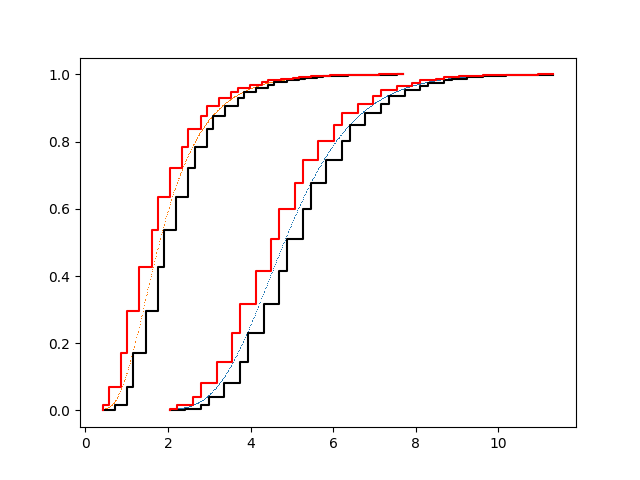

We have an average number of 0.5202913631633714 samples per bin (min: 0.0, max: 2.0, expected: 0.5202913631633714)
1.6995090753297248 0.4692716548297536


In [506]:
ax2.clear()
N_mcs = 500
# get support (define upper and lower bounds, e.g. 99 % quantiles, 1% quantiles) (truncated)
suppk = rvk.ppf([0.001,0.999])
suppm = rvm.ppf([0.001,0.999])

# sample N_mcs samples from a Halton Sequence and transform to uniform bounds
engine = scipy.stats.qmc.Halton(2)
xy = engine.random(N_mcs).T
rvuk = scipy.stats.uniform(suppk[0], suppk[1]-suppk[0])
rvum = scipy.stats.uniform(suppm[0], suppm[1]-suppm[0])
rvsk = rvuk.ppf(xy[0,:])
rvsm = rvum.ppf(xy[1,:])

# compute cdf and pdf value for each input sample
cdfk = rvk.cdf(rvsk)
pdfk = rvk.pdf(rvsk)
pdfk /= pdfk.sum()
cdfm = rvm.cdf(rvsm)
pdfm = rvm.pdf(rvsm)
pdfm /= pdfm.sum()

# compute joint pdf of each sample
pdfkm = pdfk * pdfm
pdfkm /= pdfkm.sum()

# plot input cdfs (weighted histograms)
plt.figure()
plt.plot(rvsk, cdfk, ls='none', marker=',')
# plt.hist(rvks, bins=50, histtype='step', density=True, cumulative=True
plt.plot(rvsm, cdfm, ls='none', marker=',')
# plt.hist(rvms, bins=50, histtype='step', density=True, cumulative=True)

# propagate through mapping function
fs = freq(rvsk,rvsm)

# compute and plot weighted histogram
ax2.hist(fs, bins=binsf, histtype='step', color='black', density=True, cumulative=True, weights=pdfkm)

# build hypercubes
# compute mass function of output on all input hypercubes
# larger bins artificially increase bel-pl intervals around the true cdf
# smaller bins finally reduce to singletons, converging asymptotically to the true cdf
# however break approximations of interval optimization  (no intervals exist on singletons)
binsk = np.linspace(*suppk, 31)
focalsk = np.empty((binsk.size,2))
focalsk[:,1]=binsk
focalsk[1:,0] = binsk[:-1]
focalsk[0,0] = -np.infty
massk = np.zeros(binsk.size)

binsm = np.linspace(*suppm, 31)
focalsm = np.empty((binsm.size,2))
focalsm[:,1]=binsm
focalsm[1:,0] = binsm[:-1]
focalsm[0,0] = -np.infty
massm = np.zeros(binsm.size)

nbins = binsk.size * binsm.size
focalsf = np.zeros((nbins, 2))
massf = np.zeros(nbins)
samplesperbin = np.zeros(nbins)

for i in range(binsk.size):
    lbink,ubink = focalsk[i,:] 
        
    indk = np.logical_and(rvsk>lbink, rvsk<=ubink)
    if not indk.any(): continue
        
    massk[i] = np.sum(pdfk[indk])
    
    for j in range(binsm.size):
        lbinm, ubinm = focalsm[j,:]
        indm = np.logical_and(rvsm>lbinm, rvsm<=ubinm)
        if not indm.any(): continue

        massm[j] = np.sum(pdfm[indm])
        
        indkm = np.logical_and(indk, indm)
        if not indkm.any(): continue
            
        samplesperbin[i*binsm.size+j] = np.sum(indkm)
        focalsf[i*binsm.size+j,:] = (fs[indkm].min(), fs[indkm].max())
        massf[i*binsm.size+j] = np.sum(pdfkm[indkm]) 
print(f'We have an average number of {np.mean(samplesperbin)} samples per bin (min: {np.min(samplesperbin)}, max: {np.max(samplesperbin)}, expected: {N_mcs/nbins})')

# generate finer bins and compute and pl
for supp,focals,mass in zip([suppk,suppm],
                            [focalsk,focalsm],
                            [massk,massm]):
    bins = np.linspace(*supp,)
    bel = np.zeros(bins.size)
    pl = np.zeros(bins.size)
    ubin = -np.infty
    for i in range(bins.size):
        lbin = ubin
        ubin = bins[i]

        # get all sets B that are a subset of A
        # that means the lower boundary of B must be greater or equal to the lower boundary of A and similarly for the upper boundary
        belinds = np.logical_and(focals[:,0] >=-np.infty,
                                 focals[:,1] <= ubin)
        bel[i] = np.sum(mass[belinds])
        # get all sets B that intersect with A
        # that means the lower boundary of B must not be higher (= must be strictly lower) than the upper boundary of A (B entirely outside of A to the right)
        # and the upper boundary of B must not be lower (= must be strictly higher) than the lower boundary of A (B  entirely outside of A to the left)
        plinds = np.logical_and(focals[:,0]<ubin, 
                                focals[:,1]>-np.infty, )
        pl[i] = np.sum(mass[plinds])

    bel[-1]=bel[-2]
    pl[-1]=pl[-2]
    plt.step(bins, bel, c='k', where='post')
    plt.step(bins, pl, c='r', where='pre')
    
#     plt.plot(bins, bel, c='k', ls='none', marker='x')
#     plt.plot(bins, pl, c='r', ls='none', marker='x')

# generate evenly distributed bins for fs
# binsf = np.linspace(fs.min(),fs.max(), 201)
# using the same bins as the histogram in the above cell
bel = np.zeros(binsf.size)
pl = np.zeros(binsf.size)
# compute belief and plausibility for each bin

ubinf = -np.infty
for i in range(binsf.size):
    # that is set A
    lbinf = ubinf
    ubinf = binsf[i]
    # get all sets B that are a subset of A
    # that means the lower boundary of B must be greater or equal to the lower boundary of A and similarly for the upper boundary
    belinds = np.logical_and(focalsf[:,0] >=-np.infty,
                             focalsf[:,1] <= ubinf)
    bel[i] = np.sum(massf[belinds])
    # get all sets B that intersect with A
    # that means the lower boundary of B must not be higher (= must be strictly lower) than the upper boundary of A (B entirely outside of A to the right)
    # and the upper boundary of B must not be lower (= must be strictly higher) than the lower boundary of A (B  entirely outside of A to the left)
    plinds = np.logical_and(focalsf[:,0]<ubinf, 
                            focalsf[:,1]>-np.infty, )
#     print(lbinf,ubinf,belinds,plinds)
    pl[i] = np.sum(massf[plinds])
    
#     bel[i] = np.sum(pdfkm[fs<=binsf[i]])
#     pl[i] = np.sum(pdfkm[fs<=binsf[i]])
#     ax2.plot([lbinf, ubinf],[bel[i],bel[i]], c='k')
#     ax2.plot([lbinf, ubinf],[pl[i],pl[i]], c='r')



"""
Asymptotically for decreasing bin size
focal sets become singletons with mass = pdfkm
bel consists of singletons ind = [fs<=ubinf] and bel = sum(pdfkm[ind])
pl consists of singletons ind = [fs<=ubinf] and pl = sum(pdfkm[ind])
"""
bel[-1]=bel[-2]
pl[-1]=pl[-2]
ax2.step(binsf, bel, c='k', where='post')
ax2.step(binsf, pl, c='r', where='pre')
ax2.set_ylim(*ax.get_ylim())
mean=np.average(fs, weights=pdfkm)
std = np.sqrt(np.average((fs - mean)**2, weights=pdfkm))
print(mean, std)

<IPython.core.display.Javascript object>


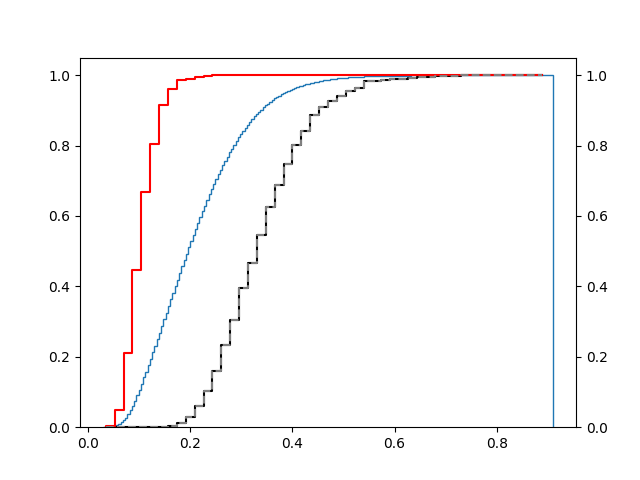

0.21208003960633345 0.09481844495489077


In [599]:
N_mcs=100000
# sample N_mcs samples from both
rvks=rvk.rvs(N_mcs)
rvms=rvm.rvs(N_mcs)
rvcs=rvc.rvs(N_mcs)
# propagate through mapping function
zetas = damp(rvks,rvms, rvcs)
# draw histogram
plt.figure()
ax = plt.gca()
ax2 = ax.twinx()
_,binszeta,_ = ax.hist(zetas, bins=200, histtype='step', density=True, cumulative=True)
# compute statistical moments
print(np.mean(zetas), np.std(zetas))

<IPython.core.display.Javascript object>


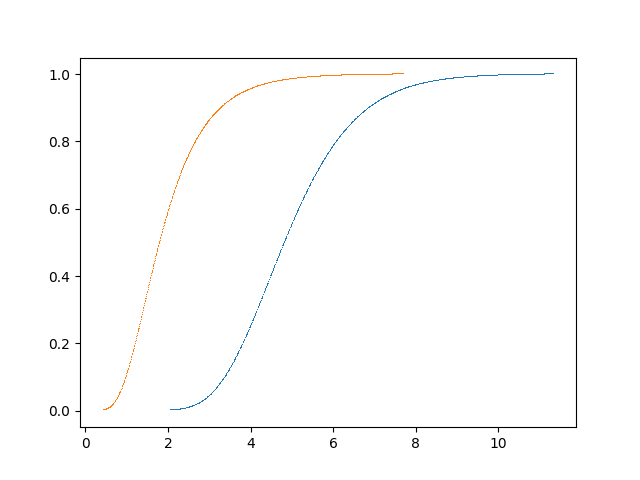

50 50 50
50 50 50


In [612]:
ax2.clear()
N_mcs_ale = 1000
N_mcs_epi = 10
N_mcs = max(N_mcs_ale,N_mcs_epi)
# get support (define upper and lower bounds, e.g. 99 % quantiles, 1% quantiles) (truncated)
suppk = rvk.ppf([0.001,0.999])
suppm = rvm.ppf([0.001,0.999])
suppc = ivc
# define equivalent uniform distributions
rvuk = scipy.stats.uniform(suppk[0], suppk[1]-suppk[0])
rvum = scipy.stats.uniform(suppm[0], suppm[1]-suppm[0])
rvuc = scipy.stats.uniform(suppc[0], suppc[1]-suppc[0])

# sample N_mcs samples from a Halton Sequence and transform to uniform bounds
engine = scipy.stats.qmc.Halton(3)
samples = engine.random(N_mcs)
samples_ale = samples[:N_mcs_ale, 0:2]
for i, rvu in enumerate([rvuk, rvum]):
    samples_ale[:, i] = rvu.ppf(samples_ale[:, i])
samples_epi = samples[:N_mcs_epi, 2:3]
for i, rvu in enumerate([rvuc]):
    samples_epi[:, i] = rvu.ppf(samples_epi[:, i])

# generate grid indices
ind_ale, ind_epi = np.mgrid[0:N_mcs_ale:1, 0:N_mcs_epi:1]
ind_alef = ind_ale.flatten()
ind_epif = ind_epi.flatten()

# compute cdf and pdf value for each input sample
cdfk = rvk.cdf(samples_ale[:, 0])
pdfk = rvk.pdf(samples_ale[:, 0])
pdfk /= pdfk.sum()
cdfm = rvm.cdf(samples_ale[:, 1])
pdfm = rvm.pdf(samples_ale[:, 1])
pdfm /= pdfm.sum()

# compute joint pdf of each sample
pdfkm = pdfk * pdfm
pdfkm /= pdfkm.sum()

# plot input cdfs (weighted histograms)
plt.figure()
plt.plot(samples_ale[:, 0], cdfk, ls='none', marker=',')
# plt.hist(rvks, bins=50, histtype='step', density=True, cumulative=True
plt.plot(samples_ale[:, 1], cdfm, ls='none', marker=',')
# plt.hist(rvms, bins=50, histtype='step', density=True, cumulative=True)

# propagate through mapping function
zetas = damp(samples_ale[ind_alef, 0],samples_ale[ind_alef, 1], samples_epi[ind_epif, 0])

'''
for each epistemic sample: draw histograms -> find min max
for each aleatory sample: draw intervals -> find distribution
'''
binszetas = np.linspace(zetas.min(), zetas.max(), N_mcs_ale//20) # on average 20 aleatory samples per bin

if True:
    focalszeta = np.zeros((N_mcs_ale,3)) #min, max, mass
    for j in range(N_mcs_ale):
        ind = ind_alef==j
        if not ind.any(): continue

        this_zetas = zetas[ind]
        mass = np.sum(pdfkm[j])
        focalszeta[j] = [np.min(this_zetas),np.max(this_zetas),mass]

    bel = np.zeros(binszetas.size)
    pl = np.zeros(binszetas.size)
    ubinzeta = -np.infty
    for i,binzeta in enumerate(binszetas):
        lbinzeta = ubinzeta
        ubinzeta = binzeta
        # get all sets B that are a subset of A
        # that means the lower boundary of B must be greater or equal to the lower boundary of A and similarly for the upper boundary
        belinds = np.logical_and(focalszeta[:,0] >=-np.infty,
                                 focalszeta[:,1] <= ubinzeta)
        bel[i] = np.sum(focalszeta[belinds,2])
        # get all sets B that intersect with A
        # that means the lower boundary of B must not be higher (= must be strictly lower) than the upper boundary of A (B entirely outside of A to the right)
        # and the upper boundary of B must not be lower (= must be strictly higher) than the lower boundary of A (B  entirely outside of A to the left)
        plinds = np.logical_and(focalszeta[:,0]<ubinzeta, 
                                focalszeta[:,1]>-np.infty, )
    #     print(lbinf,ubinf,belinds,plinds)
        pl[i] = np.sum(focalszeta[plinds,2])
    bel[-1]=bel[-2]
    pl[-1]=pl[-2]
    
    print(binszetas.size, bel.size, pl.size)
    ax2.step(binszetas, bel, c='k', where='post')
    ax2.step(binszetas, pl, c='r', where='pre')
    ax2.set_ylim(*ax.get_ylim())    

if True:
    bel = np.ones_like(binszetas)
    pl = np.zeros_like(binszetas)
    for i in range(N_mcs_epi):
        this_zetas = zetas[ind_epif==i]
        hist,_ = np.histogram(this_zetas, bins=np.hstack([np.array([-np.infty]),binszetas]), weights=pdfkm, density=True)
        hist = np.cumsum(hist)
        hist /=hist.max()
        plinds = pl<hist
        pl[plinds] = hist[plinds]
        belinds = bel>hist
        bel[belinds] = hist[belinds]
    print(binszetas.size, bel.size, pl.size)
    ax2.step(binszetas, bel, c='grey', ls='dashed', where='post')
    ax2.step(binszetas, pl, c='lightred', ls='dashed',  where='pre')
    ax2.set_ylim(*ax.get_ylim())   
        

In [529]:
Nsamples=10000
Nperhypercube=11
for Nvariables in range(1,20):
    Nbins = (Nsamples/Nperhypercube)**(1/Nvariables)
    print(Nvariables, Nbins)
    
Nbins=10
for Nvariables in range(1,20):
    Nperhypercube = Nsamples/(Nbins**Nvariables)
    print(Nvariables, Nperhypercube)

Nperhypercube = 10
Nbins = 10
for Nvariables in range(1,20):
    Nsamples = Nperhypercube*(Nbins**Nvariables)
    print(Nvariables, Nsamples)

1 909.0909090909091
2 30.15113445777636
3 9.68729306151464
4 5.4910048677611245
5 3.9059030831128663
6 3.112441655921383
7 2.6464164524353273
8 2.343289326515427
9 2.1317395666293653
10 1.9763357718547894
11 1.8576517513630824
12 1.7642113410590532
13 1.6888270562219956
14 1.6267810093664503
15 1.5748546882802004
16 1.5307806265155786
17 1.4929172096235401
18 1.4600477960085299
19 1.4312522237943601
1 1000.0
2 100.0
3 10.0
4 1.0
5 0.1
6 0.01
7 0.001
8 0.0001
9 1e-05
10 1e-06
11 1e-07
12 1e-08
13 1e-09
14 1e-10
15 1e-11
16 1e-12
17 1e-13
18 1e-14
19 1e-15
1 100
2 1000
3 10000
4 100000
5 1000000
6 10000000
7 100000000
8 1000000000
9 10000000000
10 100000000000
11 1000000000000
12 10000000000000
13 100000000000000
14 1000000000000000
15 10000000000000000
16 100000000000000000
17 1000000000000000000
18 10000000000000000000
19 100000000000000000000


In [425]:
Nperhypercube = Nsamples/(Nbins**Nvariables)
Nbins = Nsamples/Nperhypercube**(1/Nvariables)

1470.3265871337283

 * interval approximation of aleatory variables generates 
$$n_{HyperCubes} = n_{intervals}^{n_{variables}}$$ hypercubes

 * if additional epistemic variables are taken into account
$$n_{HyperCubes} = \Pi_{j=1}^{n_{variables}} n_{intervals,j}$$

 * interval optimization must be performed on each hypercube

 * if that is to be approximated by uniform low discrepancy sampling, each hypercube must contain a sufficient (> 10) amount of samples

 * so the total amount of samples must be
$$N_{samples} > 10  n_{HyperCubes}$$

 * assuming $n_{variables} = 10$ and $n_{intervals} = 10$ the $n_{samples}= 1e12$ which is impractical


* * another option: treat aleatory variables with uniform low-discrepancy sampling over the support

 * weight each sample by the product of PDFS
$$m=\Pi_{n_variables} f_X{x}$$

 * for each aleatory sample do an epistemic inner loop

 * essentially fixing the aleatory variables and do interval optimization over all epistemic hypercubes

 * which may be approximated by low discrepancy sampling

 * that allows to:
   * increase sample size in both dimensions after uncertainty propagation
   * approximate first- (and possibly higher-) order sensitivities (Marzban, Lahmer)
   * change the type or parameters of both types of variables afterwards (as long as the support is not extended)
   * makes fuzzy-random-fuzzy evaluation a postprocessing step, where $alpha$-levels and distributions parameters may be varied as long as all of the support is covered
   * fuzzy random variables (fuzzy sets whose interval bounds at $\alpha$-level are defined by marginal random variables $X_{\alpha,l}, X_{\alpha,r}$) 
     * outer loop aleatory samples readily define interval bounds for the inner loop, for each aleatory sample we get an interval, cdfs of these bounds can then be plotted
   * fuzzy probability based random variable (families of random variables defined by fuzzy sets, for a given set $I$ e.g. $X<x$ lower and upper probabilities $[\underline{P_X}(I),\overline{P_X}(I)]$ are obtained due to a fuzzy representation of the underlying distribution) 
     * from the fuzzy representation pre-compute the largest extent of the support of aleatory variables, 
     * sample low-discrepancy sequences from this support in an outer (aleatory) loop, 
     * for each aleatory sample generate epistemic low discrepancy sequences (possibly repeatedly use the same epistemic sequences, that way inner/outer loope can be interpreted either way as aleatory/epistemic or epistemic/aleatory) 
     * finally create epistemic bins from the combined inner-outer loop samples and compute cdfs for each epistemic bin,
     * find the mimimum and maximum value for each aleatory cdf bin of the respective epistemic bins (or use kolmogorov-smirnov distance or similar measures for interval optimization)
   * fuzzy probability based fuzzy random variable
     * pre-processing: find the support for all variables involved, sample aleatory and epistemic sequences
     * post-processing: assign probabilies to each sample, perform interval optimization
  
        


### CONTINUE ###

* Formalize the working example
* Implement the three types of fuzzy-randomness with the example of evidential beam using the above method
* implement this method into datamanager (take a backup first)


1554722490
(50, 50)
RMSE interp 1.1122449718794325


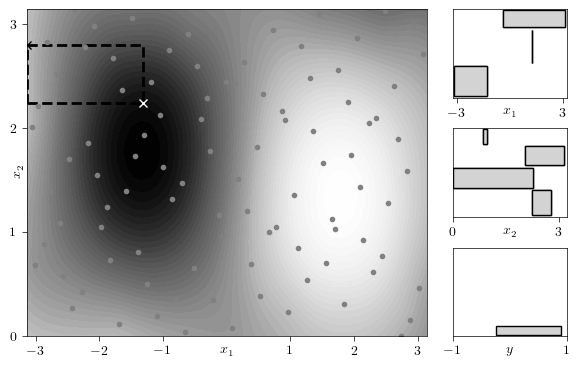

123 0


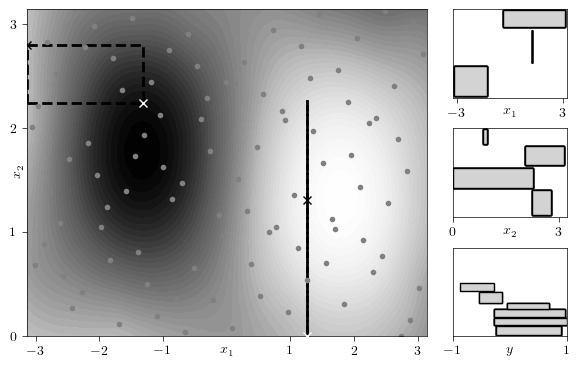

123 0


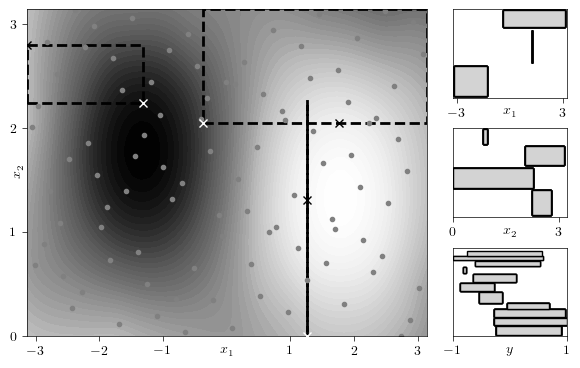

123 0


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
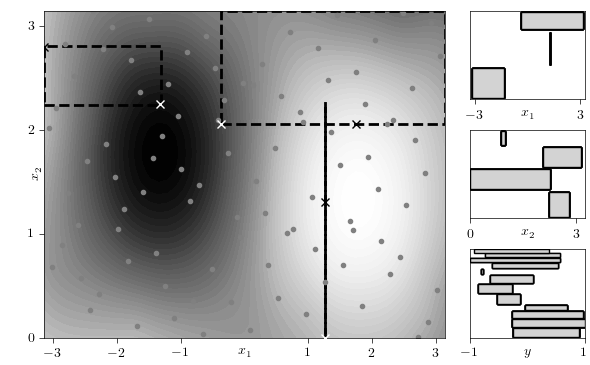

In [187]:
from scipy.interpolate import RBFInterpolator
from matplotlib.patches import Rectangle
import scipy.optimize

from uncertainty.polymorphic_uncertainty import *
with matplotlib.rc_context(get_pcd()):
    nfocals1=3
    nfocals2=4
    seed = np.random.randint(np.iinfo(np.int32).max)
    print(seed)
#     seed = 1544723245
    seed = 2088562039
    rng = np.random.default_rng(seed)

    mass1 =rng.random(nfocals1)
    focals1 = np.empty((nfocals1,2))
    focals1[:,0] = rng.random(nfocals1)
    focals1[:,1] =  focals1[:,0] + rng.random(nfocals1)
    focals1 = focals1*3-3
    focals1[1,1]=focals1[1,0] # singleton set
    focals1 -= focals1.min()
    focals1 /= focals1.max()
    focals1 *= 2*np.pi
    focals1 -= np.pi
    mass1 /= mass1.sum()


    mass2 =rng.random(nfocals2)
    focals2 = np.empty((nfocals2,2))
    focals2[:,0] = rng.random(nfocals2)
    focals2[:,1] =  focals2[:,0] + rng.random(nfocals2)
    focals2 *= 1.5
    focals2 -= focals2.min()
    focals2 /= focals2.max()
    focals2 *= np.pi
    mass2 /= mass2.sum()

    # plot focal sets and masses
    fig = plt.figure()#figsize=(0.6*5.53,2.96))

    gs = fig.add_gridspec(3, 2,  width_ratios=(7, 2))

    ax = fig.add_subplot(gs[:, 0])
    ax1 = fig.add_subplot(gs[0, 1])
    ax2 = fig.add_subplot(gs[1, 1])
    ax3 = fig.add_subplot(gs[2, 1])

    ax1.set_xlim((-3,3))
    ax1.set_ylim(( 0,1))
    ax1.set_yticks([])

    ax2.set_xlim(( 0,3))
    ax2.set_ylim(( 0,1))
    ax2.set_yticks([])

    ax3.set_xlim((-1,1))
    ax3.set_ylim(( 0,1))
    ax3.set_yticks([])

    plot_focals(focals1, mass1, ax1)
    plot_focals(focals2, mass2, ax2)


    x=np.linspace(-np.pi, np.pi)
    y=np.linspace(0, np.pi)
    xgrid = np.mgrid[-np.pi:np.pi:50j, 0:np.pi:50j]
    X,Y = xgrid
    Z_orig = sin_exmpl(X,Y)
#     mappable = ax.contourf(X,Y,Z,levels=50, cmap='Greys', vmin=-1, vmax=1)
    print(Z_orig.shape)


    N_mcs=95

    engine = scipy.stats.qmc.Halton(2)
    xy = engine.random(N_mcs).T

    xy[0,:] = scipy.stats.uniform(np.min(x), np.max(x)-np.min(x)).ppf(xy[0,:])
    xy[1,:] = scipy.stats.uniform(np.min(y), np.max(y)-np.min(y)).ppf(xy[1,:])

    z = sin_exmpl(xy[0,:],xy[1,:])
    interp = RBFInterpolator(xy.T, z)
    
    X_,Y_ = np.meshgrid(x,y)
    Z = interp(np.vstack([X_.flatten(), Y_.flatten()]).T).reshape((len(x),len(y)))
    mappable = ax.contourf(X_,Y_,Z,levels=50, cmap='Greys', vmin=-1, vmax=1)
    
    print(f'RMSE interp {np.sqrt(np.mean(np.power((Z_orig.T - Z)/2,2)))*100}')
    
    ax.plot(*xy, ls='none', marker='.', markerfacecolor='#808080', markeredgecolor='#808080', label='Halton sequence')

    ax.set_xlabel('$x_1$', labelpad=-10)
    ax.set_yticks([0,1,2,3])
    ax.set_xticks([-3,-2,-1,1,2,3])
    ax.set_ylabel('$x_2$', labelpad=-10)
    ax1.set_xlabel('$x_1$', labelpad=-10)
    ax2.set_xlabel('$x_2$', labelpad=-10)
    ax3.set_xlabel('$y$', labelpad=-10)
    ax1.set_xticks([-3,3])
    ax2.set_xticks([0,3])
    ax1.set_xlim([-np.pi-0.1,np.pi+0.1])
    ax2.set_xlim([0,np.pi+0.1])
    ax3.set_xticks([-1,1])

    fig.subplots_adjust(top=0.97,bottom=0.075, left=0.075, right=0.99, hspace=0.35, wspace=0.1)
    
#     cbar = fig.colorbar(mappable)
#     cbar.set_label('Obective value')
#     cbar.set_ticks([-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1])
#     plt.clim(-1,1)
    
    focals3 = []
    mass3 = []
    bounds = [[0,0],[0,0,]]
    rect, maxp,minp = None,None,None
    for i1 in range(nfocals1):
        bounds[0] = focals1[i1,:]
        xl, xu = focals1[i1,:]
        for i2 in range(nfocals2):
            for po in [rect, maxp,minp]:
                if po is not None:
                    pass
#                     po.remove()
            bounds[1] = focals2[i2,:]
            yl, yu = focals2[i2,:]
            n_opt_vars = 2
            init = np.array([np.mean(bound) for bound in bounds])[:, np.newaxis]
            
            resl = scipy.optimize.differential_evolution(
                lambda x:  interp(x[np.newaxis,:n_opt_vars]) - interp(x[np.newaxis,n_opt_vars:]), 
                np.vstack([bounds, bounds]), polish=False, init='halton',)

            xoptl=resl.x[:n_opt_vars]
            xopth=resl.x[n_opt_vars:]
            fl = interp(xoptl[np.newaxis,:])
            fu = interp(xopth[np.newaxis,:])


#             resl = scipy.optimize.minimize(lambda x:  interp(x[np.newaxis,:]), init,  method='Nelder-Mead', bounds=bounds)
#             assert resl.success
#             fl = resl.fun
#             xoptl = resl.x
#             resu = scipy.optimize.minimize(lambda x: -interp(x[np.newaxis,:]), init,  method='Powell',  bounds=bounds)
#             assert resu.success
#             fu = resu.fun
#             xopth = resu.x
            focals3.append([fl, fu])
            mass3.append(mass1[i1]*mass2[i2])

            plot_focals(focals1, mass1, ax1)#, i1)
            plot_focals(focals2, mass2, ax2)#, i2)
            plot_focals(focals3, mass3, ax3)#, i1*nfocals2 + i2)
            
            if i1!=i2: continue
            
#             rect = ax.add_patch(Rectangle((xl, yl), xu - xl, yu - yl, color='red', alpha=0.25))
            rect = ax.add_patch(Rectangle((xl, yl), xu - xl, yu - yl, facecolor='none', edgecolor='black', ls='dashed', lw=2))

            maxp = ax.plot(*xopth, ls='none', marker='x', color='white', label='maximum', zorder=10)[0]
            minp = ax.plot(*xoptl, ls='none', marker='x', color='black', label='minimum', zorder=10)[0]

            plt.draw()
            display(fig)
            abc = input('123')
            plt.savefig(f'/usr/scratch4/sima9999/work/2019_OMA_UQ/tex/figures/uncertainty/cart_hyc_opt_{i1*nfocals2 + i2}.png')
            plt.savefig(f'/usr/scratch4/sima9999/work/2019_OMA_UQ/tex/figures/uncertainty/cart_hyc_opt_{i1*nfocals2 + i2}.pdf')

    # ax.legend(loc='upper right')


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
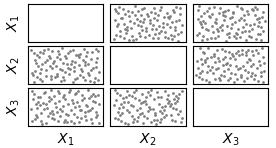

In [116]:
engine = scipy.stats.qmc.Halton(3)
samp = engine.random(100)
fig, axes = plt.subplots(3,3, sharex=True, sharey=True, figsize=(5.53/2,2.96/2))
for i in range(3):
    for j in range(3):
        if axes[i,j].is_first_col():
            axes[i,j].set_ylabel(f'$X_{i+1}$')
            axes[i,j].set_yticks([])
        if axes[i,j].is_last_row():
            axes[i,j].set_xlabel(f'$X_{j+1}$')
            axes[i,j].set_xticks([])
        if i==j: continue
        axes[i,j].scatter(samp[:,i], samp[:,j], s=1,c='grey')
fig.subplots_adjust(top=0.97,bottom=0.15, left=0.1, right=0.97, hspace=0.1, wspace=0.1)
        

### Example - Penalized NearestND Interpolation with global Interval Optimization ###
- create example function: half sine in 4 dimensions $q(\mathbf{x)} = \displaystyle\prod_i \sin\left(\pi \dfrac{x_i - x_{i,l}}{x_{i,u} - x_{i,l}} \right)$
- quasi monte carlo sampling all $x_i$ and propagation to $q$

- fit a Nearest ND Interpolator: $\tilde{q}(\mathbf{x})$
- Define the objective function: $f(\mathbf{x_{l}},\mathbf{x_{u}}) = \tilde{q}(\mathbf{x_l}) - \tilde{q}(\mathbf{x_u})$ (maximize the distance between $q_l$ and $q_u$)

- on each $x_i$ define a random interval $[I_{i,l}, I_{i,u}]$  -> $1$ hypercube 
- Penalize the objective function: 
    - distance of current nearest neighbor outside hypercube boundary: $d_i = \begin{cases} (I_{i,l} - x_{i,l})^2  & x_{i,l} < I_{i,l} \\ (x_{i,u} - I_{i,u})^2  & x_{i,u} > I_{i,u} \\ 0 & \text{else} \end{cases}$
    - Penalty: $P(\mathbf{x_{l}},\mathbf{x_{u}}) = 1 - \left(\displaystyle\sum_i d_i\right)^\frac{1}{20}$
    
    - penalized objective: $\hat{f}(\mathbf{x_{l}},\mathbf{x_{u}}) =  P(\mathbf{x_{l}},\mathbf{x_{u}}) f_O(\mathbf{x_{l}},\mathbf{x_{u}})$
    

- Use a global optimizer to find $\tilde{q}_l, \tilde{q}_u$
- For comparison purposes: sample the hypercube sufficiently and find $q_l, q_u$ directly (N=4^nvars)
- define the error as $e = \left|\tilde{q}_l - q_l\right| + \left|\tilde{q}_u - q_u\right|$

- convergence study:
    - for nvars = [2...9]
        - for basis = 2...4
            - N_mcs = basis^nvars
            - for n in 30
                - sample, propagate, fit, optimize, compute error
            - compute confidence interval of error
    - plot confidence intervals vs. N_mcs (8 colored bands)

In [2]:
def fun(xi, xil, xiu):
    '''
    arguments:
    xi: np.ndarray (n_samples,nvars)
        samples, where to evaluate the function
    xil: np.ndarray(n_vars,)
        lower bound of the inputs
    xiu: np.ndarray(n_vars,)
        upper bound of the inputs
        
    returns:
    y: np.ndarray (n_samples)
        evaluated function
    
    '''
    return np.product(np.sin(np.pi*(xi - xil)/(xiu - xil)),axis=1)

def fun_mech(ki, *args):
    '''
    Arguments:
    ki: np.ndarray(n_samples, nvars)
        list of spring stiffnesses of a rod that is divided into unit masses
    '''
    
    Ki = ki[:,:-1] + ki[:,1:]
    
    eye = np.eye(Ki.shape[1])
    return np.apply_along_axis(lambda x: np.abs(scipy.linalg.eig(np.diag(x), eye)[0][0]), axis=1, arr=Ki)


In [3]:
def wrapper(x,interp,temp_x,unit_bounds,dists,opt_vars, n_opt_vars,**kwargs):
    '''
    interpolator output is in physical space

    objective is to maximize interval
    i.e. minimize lower - upper -> in [-infty, 0]
    
    LinearND solutions may return nan, when outside the convex hull
        return 0
    
    NearestND solutions violate boundaries (intentionally in some cases)
    
        as there might be singular boundaries in some dimensions, it may happen
        that there are no points inside the boundaries of that dimension
        we would want to find a nearest point, that is inside the domain in as many dimensions as possible

        we can get the nearest point itself and compute the distance to the boundaries
        all computations must be performed in the unit cube
        get the nearest point
        for each dimension:
            if outside bounds -> compute distance
        compute power(sum(distances**2), 1/20) -> distance in [0,1]
        distance may become > 1, when optimizer leaves boundaries

        multiply objective by (1-distance) -> 
            for low/no distances keeps the objective
            for high distances drives it towards 0
        
        
    '''
#     if kwargs.get('pr',False): print('bounds', unscale(unit_bounds))
    
    dist = 0
    temp_x[opt_vars] = x[:n_opt_vars,np.newaxis]
#     if kwargs.get('pr',False): print('temp_x_l',unscale(temp_x.T))
    if isinstance(interp, scipy.interpolate.NearestNDInterpolator):
        nx,yl = interp.point_val(temp_x.T)
#         if kwargs.get('pr',False): print('nx_l,yl',unscale(nx),yl)

        dists[:] = unit_bounds[:,0] - nx
#         if kwargs.get('pr',False): print('unit_bounds[:,0] - nx',dists)
        dist += np.sum(dists[dists>0]**2)
        dists[:] = nx - unit_bounds[:,1]
#         if kwargs.get('pr',False): print('nx - unit_bounds[:,1]',dists)
        dist += np.sum(dists[dists>0]**2)
    else:
        yl = interp(temp_x.T)
        if np.isnan(yl): return 0

    temp_x[opt_vars] = x[n_opt_vars:,np.newaxis]
#     if kwargs.get('pr',False): print('temp_x_h',unscale(temp_x.T))

    if isinstance(interp, scipy.interpolate.NearestNDInterpolator):
        nx,yh = interp.point_val(temp_x.T)
#         if kwargs.get('pr',False): print('nx_h,yh',unscale(nx),yh)

        dists[:] = unit_bounds[:,0] - nx
#         if kwargs.get('pr',False): print('unit_bounds[:,0] - nx',dists)
        dist += np.sum(dists[dists>0]**2)
        dists[:] = nx - unit_bounds[:,1]
#         if kwargs.get('pr',False): print('nx - unit_bounds[:,1]',dists)
        dist += np.sum(dists[dists>0]**2)
    else:
        yh = interp(temp_x.T)
        if np.isnan(yh): return 0
        

#     if kwargs.get('pr',False): print('dist',dist)
    dist = np.power(dist, 1/20)
#     if kwargs.get('pr',False): print('dist sqrt',dist)
    # for testing purposes
#     if dist > 1 and not kwargs.get('pr',False):
#         print('wrapper failed, rerun with printouts enabled')
#         wrapper(x,interp,temp_x,unit_bounds,dists,opt_vars, n_opt_vars,pr=True,**kwargs)
    # yh = wrapper_sing(x[n_opt_vars:])

    y = yl - yh
#     if kwargs.get('pr',False): print('y',y)
    y *= (1 - dist)
#     if kwargs.get('pr',False): print('y pen',y)
    return y

def scale(x):
    return (x - xil)/(xiu-xil)

def unscale(x):
    return x * (xiu-xil) + xil

def plot_grid(inputs, outputs):
    global hue_norm
    hue_norm = matplotlib.colors.Normalize(3/2*np.min(outputs)-1/2*np.max(outputs),np.max(outputs))
    nvars = inputs.shape[1]
    df = pd.DataFrame(inputs, columns=[f'$x_{i}$' for i in range(nvars)])
    df['$y$']=outputs
    grid = sns.pairplot(df, hue='$y$', diag_kind='scatter', corner=True, markers='.', plot_kws={'s':25, 'hue_norm':hue_norm}, palette='cubehelix', )
    grid.fig.set_size_inches(5.92,5.92)
    grid.fig.set_dpi(150)
    grid.fig.subplots_adjust(top=0.97,bottom=0.08, left=0.12, right=0.9)
    grid.fig.align_labels()
#     print(grid.fig.legend())
    for i, x_var in enumerate(grid.x_vars):
        
        grid.axes[i,i].set_axis_off()
        ax = grid.axes[i,i].twinx()
        sns.scatterplot(data=df, x=x_var,y='$y$', hue='$y$', markers='.',s=5, palette=grid._orig_palette, hue_norm=hue_norm, ax=ax, legend=False)
        grid.axes[i,i] = ax
    global rectangles
    rectangles=[]
    global scatters
    scatters=[]
    return grid

def plot_hyc_grid(inputs_hyc, outputs_hyc, maxx, minx, fmax, fmin, grid):
    nvars = inputs_hyc.shape[1]
    df_hyc = pd.DataFrame(inputs_hyc, columns=[f'$x_{i}$' for i in range(nvars)])
    df_hyc['$y$']=outputs_hyc
    
    global scatters
    global hue_norm
    create_legend = not scatters
    
    for obj in scatters:
        obj.remove()
    scatters=[]
    for i, x_var in enumerate(grid.x_vars):
        for j, y_var in enumerate(grid.y_vars):
            if i==j: continue
            ax = grid.axes[j,i]
            if ax is None: continue
            sns.scatterplot(data=df_hyc, x=x_var,y=y_var, hue='$y$', markers='.',s=3, palette=grid._orig_palette, hue_norm=hue_norm, ax=ax, legend=False)
            scatters.append(ax.collections[-1])

            p=ax.scatter(maxx[i],maxx[j], marker='x',color='k')
            scatters.append(p)
            p=ax.scatter(minx[i],minx[j], marker='x',color='k')
            scatters.append(p)

        ax = grid.axes[i,i]

        sns.scatterplot(data=df_hyc, x=x_var,y='$y$', hue='$y$', markers='.',s=3, palette=grid._orig_palette, hue_norm=hue_norm, ax=ax, legend=False)
        scatters.append(ax.collections[-1])

        p=ax.scatter(maxx[i],fmax, marker='x',color='k')
        scatters.append(p)
        p=ax.scatter(minx[i],fmin, marker='x',color='k', label='true opt.')
        scatters.append(p)
        
    if create_legend:
        grid.fig.legends[0].legendHandles.append(p)
        grid.fig.legend(handles=grid.fig.legends[0].legendHandles, title='y')
        grid.fig.legends[0].remove()

def plot_opt_res_grid(grid, opt_vars,xl,xh, focals, minout, maxout, fmin, fmax):
    
    opt_var_inds=np.cumsum(opt_vars) - 1
    global rectangles
    
    create_legend = not rectangles
    
    for obj in rectangles:
        obj.remove()
    rectangles = []
    for i,var1 in enumerate(grid.x_vars):
        if not opt_vars[i]: continue
        opt_var_ind1 = opt_var_inds[i]
        b1 = (xl[opt_var_ind1],xh[opt_var_ind1])
        f1=focals[i]
        for j,var2 in enumerate(grid.y_vars):
            
            if not opt_vars[j]: continue
            if var1==var2: continue
            
            opt_var_ind2 = opt_var_inds[j]
            b2 = (xl[opt_var_ind2],xh[opt_var_ind2])
            ax = grid.axes[j,i]

            if ax is None: continue

            # plot nearest neighbor of optimal point
            p=ax.scatter(xl[opt_var_ind1],xl[opt_var_ind2], marker='o',edgecolors='k',color='none')
            rectangles.append(p)
            
            p=ax.scatter(xh[opt_var_ind1],xh[opt_var_ind2], marker='o',edgecolors='k',color='none')
            rectangles.append(p)

            # plot design hypercube
            f2=focals[j]
            p=ax.add_patch(Rectangle((f1[0], f2[0]), f1[1] - f1[0], f2[1] - f2[0], fill=False, ls='dashed', color='k', alpha=0.5))
            rectangles.append(p)

        #plot optimal hypercube
        ax = grid.axes[i,i]

        # plot design hypercube
        p=ax.add_patch(Rectangle((f1[0], minout), f1[1] - f1[0], maxout - minout, fill=False, ls='dashed', color='k', alpha=0.5))
        rectangles.append(p)

        b2 = (fmin,fmax)
        # plot nearest neighbor of optimal point
        p=ax.scatter(xl[opt_var_ind1],fmin, marker='o',edgecolors='k',color='none')
        rectangles.append(p)
        p=ax.scatter(xh[opt_var_ind1],fmax, marker='o',edgecolors='k', label='appr. opt.',color='none')
        rectangles.append(p)
    if create_legend:
        grid.fig.legends[0].legendHandles.append(p)
        grid.fig.legend(handles=grid.fig.legends[0].legendHandles, title='y')
        grid.fig.legends[0].remove()


In [129]:
plt.close('all')
plt.rc('text',usetex=True)
fig_path = '/usr/scratch4/sima9999/work/2019_OMA_UQ/tex/figures/uncertainty/iv_opt'
nvars = 7
N_mcs = int(4**nvars)
global xil
xil = np.random.random(nvars)*27
global xiu
xiu = xil + np.random.random(nvars)*5
xrang = xiu - xil

mapping = [fun, fun_mech][1]
if mapping == fun: fig_path += '_psin'
if mapping == fun_mech: fig_path += '_rod'

engine = scipy.stats.qmc.Halton(nvars,scramble=True)
inputs = engine.random(N_mcs)

inputs = scipy.stats.qmc.scale(inputs, xil, xiu)

In [103]:
outputs = mapping(inputs,xil,xiu)
outputs-=np.min(outputs)
outputs/=np.max(outputs)
maxout = np.max(outputs)
minout = np.min(outputs)

In [104]:
hyc_vol_frac = np.power(0.3,nvars)
hyc_vol_rem = float(hyc_vol_frac) # creates a copy

focals = np.empty((nvars,2))
for n in range(nvars - 1):
    focals[n,1] = scipy.stats.norm.rvs(hyc_vol_rem ** (1 / (nvars - n)), hyc_vol_frac, 1)
#             print(n, hyc_vol_rem, hyc_vol_rem ** (1 / (nvars - n)))
    while focals[n,1]<0:
        focals[n,1] = scipy.stats.norm.rvs(hyc_vol_rem ** (1 / (nvars - n)), hyc_vol_frac, 1)
    if focals[n,1] > 1:
        focals[n,1] = 1
    if hyc_vol_rem/focals[n,1] >1:
        focals[n,1] = 1
    hyc_vol_rem /= focals[n,1] 
focals[-1,1]  = hyc_vol_rem
#         print(focals[:,1])
#         print(np.product(focals[:,1]) , hyc_vol_frac)
if not np.isclose(np.product(focals[:,1]), hyc_vol_frac):
    print(f'hypercube volume fractions do not match {np.product(focals[:,1])}!={hyc_vol_frac}')
    print(focals)
focals[:,1] *= (np.array(xiu) - np.array(xil) )
# may choose starting point just so, that endpoint does not exceed xiu
focals[:,0] = np.random.random(nvars) * ((xiu - xil) - focals[:,1]) + xil
focals[:,1] += focals[:,0]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
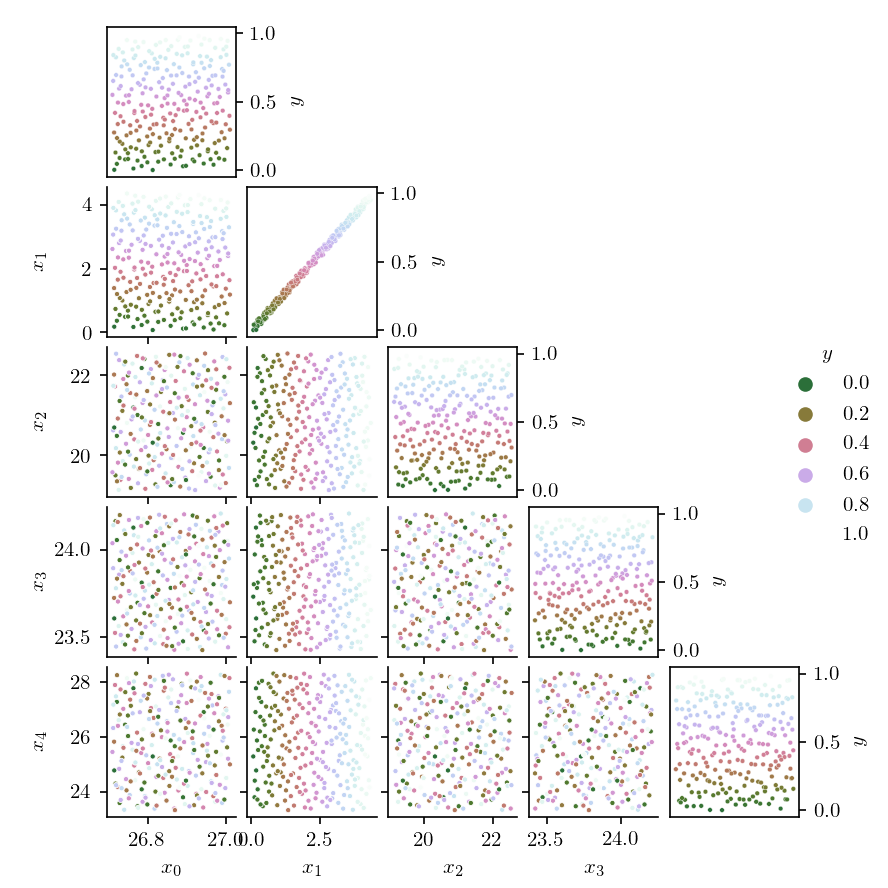

In [105]:
grid = plot_grid(inputs,outputs)


In [106]:
# grid.fig.savefig(fig_path+'_samp.pdf')
# grid.fig.savefig(fig_path+'_samp.png')


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
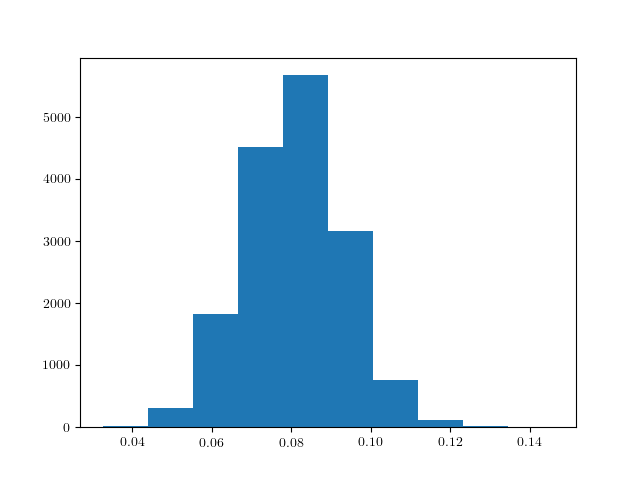

0.08074989863130555

In [130]:
unit_inp = scale(inputs)
dist = np.sqrt(np.mean((unit_inp[:,np.newaxis,:]-unit_inp[np.newaxis,:,:])**2,axis=2))
np.fill_diagonal(dist, np.nan)
dist = np.nanmin(dist, axis=1)
# dist = dist[np.tril_indices(dist.shape[0],k=-1)]

plt.figure()
plt.hist(dist)
plt.show()
avg_dist = np.mean(dist)
display(avg_dist)

In [114]:
if 0:
    interp_fun =  scipy.interpolate.NearestNDInterpolator #(scale(inputs),  outputs)
    kwargs={}
elif 1:
    interp_fun =  scipy.interpolate.RBFInterpolator #(scale(inputs),  outputs, kernel='gaussian', epsilon=5 if mapping==fun else 1)
    kwargs = dict(kernel='gaussian', epsilon=5 if mapping==fun else 0.01)
else:
    interp_fun =  scipy.interpolate.LinearNDInterpolator #(scale(inputs),  outputs)
    kwargs = {}
    
# estimate interpolator error by 
# k-runs of leave-one-out cross validation
# k-fold cross validation would be another option 
# but individual fits would use much less samples than the final interpolator
# finally use all samples for the interpolator
# k = np.arange(N_mcs) #loo 
k = np.random.randint(0, N_mcs, int(N_mcs//10)) # 10 % num sample runs of loo 
val_errs = []
ind = np.ones(N_mcs, dtype=bool)
out_range = outputs.max() - outputs.min()
# print(out_range)
for k_i in k:
    ind[k_i] = False
    interp =  interp_fun(scale(inputs[ind,:]),  outputs[ind], **kwargs)
    err = interp(scale(inputs[~ind,:])) - outputs[~ind]
    # normalize output -> (output - min(output)) / value_range(output)
    # normalize error out_intp - output - min(out_intp) + min(output) / (range(output)
    # -> err / range(output)
    err /= out_range
#     print(interp(scale(inputs[~ind,:])), outputs[~ind], err)
    val_errs.append(err)
    ind[k_i] = True
val_err = np.sqrt(np.nanmean(np.power(val_errs,2)))
print(f'normalized RMSE of interpolator using {len(k)} runs of loo validation: {val_err:1.3f}')

interp =  interp_fun(scale(inputs),  outputs, **kwargs)

engine = scipy.stats.qmc.Halton(nvars,scramble=True)
inputs_hyc = engine.random(10000)
focals_hyc = focals

inputs_hyc = scipy.stats.qmc.scale(inputs_hyc, focals_hyc[:,0], focals_hyc[:,1])

outputs_hyc = interp(scale(inputs_hyc))


if mapping==fun:
    '''
    half sine is max towards the middle
    half sine in min towards the edges
    total max is the point closest to the hypercube center
    total min is the point farthest away from the hypercube center
    '''
    midpoint = (xiu + xil)[:,np.newaxis] / 2
    dist = np.abs(focals - midpoint)
    # compute closest point to midpoint ( sin(midpoint) = max )
    maxx = np.take_along_axis(focals, np.expand_dims(np.argmin(dist,axis=1), axis=1), axis=1)
    ind = np.logical_and(focals[:,1]>midpoint.T, focals[:,0]<midpoint.T).T
    maxx[ind] = midpoint[ind]
    # compute farthes point from midpoint
    minx = np.take_along_axis(focals, np.expand_dims(np.argmax(dist,axis=1), axis=1), axis=1)

    maxout_hyc = fun(maxx.T,xil,xiu)
    minout_hyc = fun(minx.T,xil,xiu)
elif mapping==fun_mech:
    maxx = focals.max(axis=1)
    minx = focals.min(axis=1)
    maxout_hyc = fun_mech(maxx[np.newaxis,:],xil,xiu)
    minout_hyc = fun_mech(minx[np.newaxis,:],xil,xiu)

normalized RMSE of interpolator using 24 runs of loo validation: 0.000


In [115]:
# plot_hyc_grid(inputs_hyc,outputs_hyc,maxx, minx, maxout_hyc, minout_hyc,grid)
plot_hyc_grid(inputs_hyc,outputs_hyc,maxx, minx, 1, 0,grid)

In [101]:
bounds = focals

opt_vars = focals[:,0]!=focals[:,1]
n_opt_vars = np.sum(opt_vars)

# transform boundaries to unit cube for penalization
unit_bounds = np.empty_like(bounds)
for lu in range(2):
    unit_bounds[:,lu] = scale(bounds[:,lu])
dists = np.empty((1,nvars))

init = np.mean(bounds, axis=1)[:,np.newaxis]

# initialize memory for optimizing x in wrapper
temp_x = np.copy(init)

resl = scipy.optimize.differential_evolution(wrapper, 
             bounds=np.vstack([unit_bounds[opt_vars,:], unit_bounds[opt_vars,:]]),
             args=(interp,temp_x,unit_bounds,dists, opt_vars, n_opt_vars),
             polish=False,
             init='halton',
                                            )

xl=resl.x[:n_opt_vars]
xh=resl.x[n_opt_vars:]

#     wrapper(resl.x, temp_x,unit_bounds,dists, pr=True)

temp_x[opt_vars] = xl[:,np.newaxis]
fmin = interp(temp_x.T)
if isinstance(interp, scipy.interpolate.NearestNDInterpolator):
    i, dist = interp.neighbor_dist(temp_x.T)
    txl=inputs[i,opt_vars]
else:
    txl = unscale(xl)

temp_x[opt_vars] = xh[:,np.newaxis]
fmax = interp(temp_x.T)
if isinstance(interp, scipy.interpolate.NearestNDInterpolator):
    i, dist = interp.neighbor_dist(temp_x.T)
    txh=inputs[i,opt_vars]
else:
    txh = unscale(xh)

xl = unscale(xl)
xh = unscale(xh)

bl = bounds[opt_vars, 0]
bh = bounds[opt_vars, 1]

In [102]:
plot_opt_res_grid(grid, opt_vars, txl, txh, focals, minout, maxout, fmin, fmax)

In [ ]:
if isinstance(interp,scipy.interpolate.NearestNDInterpolator): name = '_nearest'
if isinstance(interp,scipy.interpolate.LinearNDInterpolator): name = '_linear'
if isinstance(interp,scipy.interpolate.RBFInterpolator): name = '_rbf'
# grid.fig.savefig(fig_path + name + '.pdf')
# grid.fig.savefig(fig_path + name + '.png')

In [4]:
def error_fun(nvars, N_mcs, hyc_vol_frac=None, mapping=fun, interp_fun=scipy.interpolate.NearestNDInterpolator, plot_res=False, **kwargs):
    # must be global for scale / unscale functions to work properly
    
    global xil
    xil = np.random.random(nvars) * 27
    global xiu
    xiu = xil + np.random.random(nvars) * 5
    xrang = xiu - xil

    engine = scipy.stats.qmc.Halton(nvars,scramble=True)
    inputs = engine.random(N_mcs)

    inputs = scipy.stats.qmc.scale(inputs, xil, xiu)
    
    outputs = mapping(inputs,xil,xiu)
    if plot_res:
        grid = plot_grid(inputs,outputs)
    
    if mapping==fun:
        maxout = 1
        minout = 0
    elif mapping==fun_mech:
        maxout = fun_mech(xiu[np.newaxis,:],xil,xiu)[0]
        minout = fun_mech(xil[np.newaxis,:],xil,xiu)[0]
    out_range = maxout - minout

    # estimate interpolator error by 
    # k-runs of leave-one-out cross validation
    # k-fold cross validation would be another option 
    # but individual fits would use much less samples than the final interpolator
    # finally use all samples for the interpolator
    # k = np.arange(N_mcs) #loo 
#     k = np.random.randint(0, N_mcs, int(N_mcs//10)) # 10 % num sample runs of loo 
    k = np.random.randint(0, N_mcs, min(N_mcs,100)) # 100 sample runs of loo 
    val_errs = []
    ind = np.ones(N_mcs, dtype=bool)
    
    if N_mcs<10*len(k): # do loo
#         print('loo')
        for k_i in k:
            ind[k_i] = False
            interp =  interp_fun(scale(inputs[ind,:]),  outputs[ind], **kwargs)
            err = interp(scale(inputs[~ind,:])) - outputs[~ind]
            # normalize output -> (output - min(output)) / value_range(output)
            # normalize error out_intp - output - min(out_intp) + min(output) / (range(output)
            # -> err / range(output)
            # -> val_errs /  range(output)
            # -> intp_err / range(output)
    #         err /= out_range
            val_errs.append(err)
            ind[k_i] = True
    else: # do lko
#         print('lko')
        ind[k]=False
        interp =  interp_fun(scale(inputs[ind,:]),  outputs[ind], **kwargs)
        val_errs = interp(scale(inputs[~ind,:])) - outputs[~ind]
    intp_err = np.sqrt(np.nanmean(np.power(val_errs, 2))) / out_range   
        
#     print(intp_err)
        
#     print(f'normalized RMSE of interpolator using {len(k)} runs of loo validation: {intp_err:1.3f}')
    
    interp =  interp_fun(scale(inputs),  outputs, **kwargs)

    focals = np.empty((nvars,2))
    if hyc_vol_frac is None:
        focals[:,0] = np.random.random(nvars) / 2 * (xiu - xil) + xil
        focals[:,1] = focals[:,0] + np.random.random(nvars) * (np.array(xiu) - focals[:,0])
    else:
        hyc_vol_rem = float(hyc_vol_frac) # creates a copy
        
        for n in range(nvars - 1):
            focals[n,1] = scipy.stats.norm.rvs(hyc_vol_rem ** (1 / (nvars - n)), hyc_vol_frac, 1)
#             print(n, hyc_vol_rem, hyc_vol_rem ** (1 / (nvars - n)))
            while focals[n,1]<0:
                focals[n,1] = scipy.stats.norm.rvs(hyc_vol_rem ** (1 / (nvars - n)), hyc_vol_frac, 1)
            if focals[n,1] > 1:
                focals[n,1] = 1
            if hyc_vol_rem/focals[n,1] >1:
                focals[n,1] = 1
            hyc_vol_rem /= focals[n,1] 
        focals[-1,1]  = hyc_vol_rem
        if not np.isclose(np.product(focals[:,1]), hyc_vol_frac):
            print(f'hypercube volume fractions do not match {np.product(focals[:,1])}!={hyc_vol_frac}')
            print(focals)
        focals[:,1] *= (np.array(xiu) - np.array(xil) )
        # may choose starting point just so, that endpoint does not exceed xiu
        focals[:,0] = np.random.random(nvars) * ((xiu - xil) - focals[:,1]) + xil
        focals[:,1] += focals[:,0]
    if np.any(focals[:,1]<focals[:,0]):
        print('something went wrong generating focals', focals)
        
    
    if mapping==fun:
        '''
        half sine is max towards the middle
        half sine in min towards the edges
        total max is the point closest to the hypercube center
        total min is the point farthest away from the hypercube center
        '''
        midpoint = (xiu + xil)[:,np.newaxis] / 2
        dist = np.abs(focals - midpoint)
        # compute closest point to midpoint ( sin(midpoint) = max )
        maxx = np.take_along_axis(focals, np.expand_dims(np.argmin(dist,axis=1), axis=1), axis=1)
        ind = np.logical_and(focals[:,1]>midpoint.T, focals[:,0]<midpoint.T).T
        maxx[ind] = midpoint[ind]
        # compute farthes point from midpoint
        minx = np.take_along_axis(focals, np.expand_dims(np.argmax(dist,axis=1), axis=1), axis=1)

        maxout_hyc = fun(maxx.T,xil,xiu)
        minout_hyc = fun(minx.T,xil,xiu)
    elif mapping==fun_mech:
        maxx = focals.max(axis=1)
        minx = focals.min(axis=1)
        maxout_hyc = fun_mech(maxx[np.newaxis,:],xil,xiu)
        minout_hyc = fun_mech(minx[np.newaxis,:],xil,xiu)

    hyc_foc_inds = list(product(*[range(2) for _ in range(nvars)]))
    
    focals_hyc = focals
    
    if plot_res:
        inputs_hyc = engine.random(1000)

        inputs_hyc = scipy.stats.qmc.scale(inputs_hyc, focals_hyc[:,0], focals_hyc[:,1])
#         outputs_hyc = fun(inputs_hyc,xil,xiu)
        outputs_hyc = interp(scale(inputs_hyc))
        plot_hyc_grid(inputs_hyc,outputs_hyc,maxx, minx, maxout_hyc, minout_hyc,grid)
    
    bounds = focals_hyc
#     print(bounds.shape)
    opt_vars = focals[:,0]!=focals[:,1]# focals are not a singleton
    n_opt_vars = np.sum(opt_vars)
    
    # transform boundaries to unit cube for penalization
    unit_bounds = np.empty_like(bounds)
    for lu in range(2):
#         unit_bounds[:,lu] = interp._scale_x(bounds[:,lu])
        unit_bounds[:,lu] = scale(bounds[:,lu])
    
    hyc_vol_frac = np.product(unit_bounds[:,1] - unit_bounds[:,0])
    
    dists = np.empty((1,nvars))

    init = np.mean(bounds, axis=1)[:,np.newaxis]

    # initialize memory for optimizing x in wrapper
    temp_x = np.copy(init)
    
    resl = scipy.optimize.differential_evolution(wrapper, 
                 np.vstack([unit_bounds[opt_vars,:], unit_bounds[opt_vars,:]]),
                 args=(interp,temp_x,unit_bounds,dists, opt_vars, n_opt_vars),
                 polish=False,
                 init='halton',)
    
    xl=resl.x[:n_opt_vars]
    xh=resl.x[n_opt_vars:]
    
    temp_x[opt_vars] = xl[:,np.newaxis]
    fmin = interp(temp_x.T)
    if isinstance(interp, scipy.interpolate.NearestNDInterpolator):
        i, dist = interp.neighbor_dist(temp_x.T)
        txl=inputs[i,opt_vars]
    else:
        txl = unscale(xl)

    temp_x[opt_vars] = xh[:,np.newaxis]
    fmax = interp(temp_x.T)
    if isinstance(interp, scipy.interpolate.NearestNDInterpolator):
        i, dist = interp.neighbor_dist(temp_x.T)
        txh=inputs[i,opt_vars]
    else:
        txh = unscale(xh)
    if plot_res:
        plot_opt_res_grid(grid, opt_vars, txl, txh, focals, minout, maxout, fmin, fmax)

    '''
    How do we have to normalize the error? 
        - Divide by the true value: Problem, when it becomes 0 or very small
        - divide by the output range inside the contraint hypercube -> that's it for the optimization error
        - divide by the output range inside the sample hypercube -> that is the one for the cross-validation error
    '''
    
    tot_err = np.abs((maxout_hyc - fmax)/(maxout_hyc - minout_hyc)) + np.abs((minout_hyc - fmin)/(maxout_hyc - minout_hyc))
    
    return tot_err, intp_err, hyc_vol_frac

if False:
    nvars = np.random.randint(2,9,1)[0]
    hyc_vol_frac = np.random.random(1)[0]/2
    basis = np.random.uniform(3,4,1)[0]
    nvars=4
    basis=3
    hyc_vol_frac=0.4
    print(nvars,int(basis**nvars),hyc_vol_frac)
    n_mcs = int(basis**nvars)
    n_mcs = 999

    # error_fun(nvars, n_mcs, hyc_vol_frac, mapping=fun_mech, interp_fun=scipy.interpolate.RBFInterpolator, kernel='gaussian', epsilon=5,plot_res=True)
    error_fun(nvars, n_mcs, hyc_vol_frac, mapping=fun_mech, interp_fun=scipy.interpolate.NearestNDInterpolator, plot_res=False)
    # error_fun(nvars, n_mcs, hyc_vol_frac, mapping=fun, interp_fun=scipy.interpolate.LinearNDInterpolator, plot_res=True)

In [33]:
N_runs = 100
N_vars = np.arange(2,10)
# bases = np.linspace(2,4,10)
N_mcs = np.floor(np.logspace(np.log10(3**N_vars.min()),np.log10(4**N_vars.max()),20)).astype(int)
tot_errs = np.zeros((len(N_vars),N_mcs.shape[0],N_runs))
intp_errs = np.zeros((len(N_vars),N_mcs.shape[0],N_runs))
vol_fracs = np.zeros((len(N_vars),N_mcs.shape[0],N_runs))

mapping = [fun, fun_mech][0]

if 0:
    interp_fun =  scipy.interpolate.NearestNDInterpolator #(scale(inputs),  outputs)
    # generally fastest and needs least CPU adn memory
    kwargs={}
elif 1:
    interp_fun =  scipy.interpolate.RBFInterpolator #(scale(inputs),  outputs, kernel='gaussian', epsilon=5 if mapping==fun else 1)
    # need lots of memory
    kwargs = dict(kernel='gaussian', epsilon=5 if mapping==fun else 1)
else:
    interp_fun =  scipy.interpolate.LinearNDInterpolator #(scale(inputs),  outputs)
    # need lots of cpu and fails for N>9 (?)
    kwargs = {}
    
npzpath = '/usr/scratch4/sima9999/work/modal_uq/convergence_iv_opt_'
if mapping==fun:
    npzpath += 'psin_'
elif mapping==fun_mech:
    npzpath += 'rod_'
if interp_fun is scipy.interpolate.NearestNDInterpolator: npzpath += 'nearest.npz'
if interp_fun is scipy.interpolate.LinearNDInterpolator: npzpath += 'linear.npz'
if interp_fun is scipy.interpolate.RBFInterpolator: npzpath += 'rbf.npz'

if os.path.exists(npzpath):
    in_dict = np.load(npzpath)
    N_vars = in_dict['N_vars']
    tot_errs = in_dict['tot_errs']
    intp_errs = in_dict['intp_errs']
    N_mcs = in_dict['N_mcs']
    vol_fracs = in_dict['vol_fracs']

In [85]:
plt.close('all')
ray.shutdown()

In [ ]:
ray.init(address='auto', _redis_password='5241590000000000')
futures = []

@ray.remote
def sub(i,j,n,nvars,n_mcs, **kwargs):
    tot_err, intp_err, vol_frac = error_fun(nvars, n_mcs, mapping=mapping, interp_fun=interp_fun, **kwargs)
    return i,j,n,tot_err, intp_err,vol_frac

for j, n_mcs in enumerate(N_mcs):
    if j<1: continue
    if n_mcs>50000: continue
    for i,nvars in enumerate(N_vars):
#     if nvars<6: continue
#     print(f'nvars={nvars}')
#         print(f'n_mcs = {n_mcs}')
        for n in range(N_runs):
            if tot_errs[i,j,n] != 0: continue
            futures.append(sub.remote(i,j,n,nvars,n_mcs,**kwargs))
            
futures = set(futures)
while True:
    ready, wait = ray.wait(list(futures), num_returns=min(len(futures), 100), timeout=180)
    
    try:
        ret_sets = ray.get(ready)
        for i,j,n,tot_err,intp_err,vol_frac in ret_sets:
            tot_errs[i,j,n] = tot_err
            intp_errs[i,j,n] = intp_err
            vol_fracs[i,j,n] = vol_frac
        size_before = len(futures)
        futures.difference_update(ready)
        print(f"Finished {len(ready)} samples. Remaining {len(futures)} samples. (before {size_before})")
    except Exception as e:
        print(e)
        pass
    if len(futures) == 0:
        break
        

In [38]:

np.savez(npzpath, **{'N_vars':N_vars,'tot_errs':tot_errs,'intp_errs':intp_errs,'N_mcs':N_mcs,'vol_fracs':vol_fracs})

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
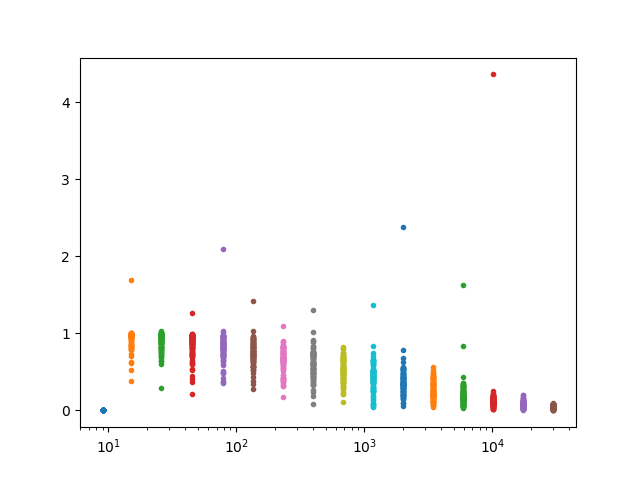

In [58]:
N_runs = 100
map_ = ['psin','rod'][0]
intp = ['nearest','linear','rbf'][2]
in_dict = np.load(f'/usr/scratch4/sima9999/work/modal_uq/convergence_iv_opt_{map_}_{intp}.npz')
N_vars = in_dict['N_vars']
tot_errs = in_dict['tot_errs'] # (len(N_vars),N_mcs.shape[0],N_runs)
intp_errs = in_dict['intp_errs'] # (len(N_vars),N_mcs.shape[0],N_runs)
N_mcs = in_dict['N_mcs']
vol_fracs = in_dict['vol_fracs'] # (len(N_vars),N_mcs.shape[0],N_runs)
n_var = 5
plt.figure()
for i, n_mcs in enumerate(N_mcs):
    if n_mcs>50000: continue
#     plt.plot(np.ones(N_runs)*n_mcs,intp_errs[n_var,i,:], ls='none',marker='.')
    errs = tot_errs[n_var,i,:]
    errs
    plt.plot(np.ones(N_runs)*n_mcs,errs, ls='none',marker='.')
plt.xscale('log')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
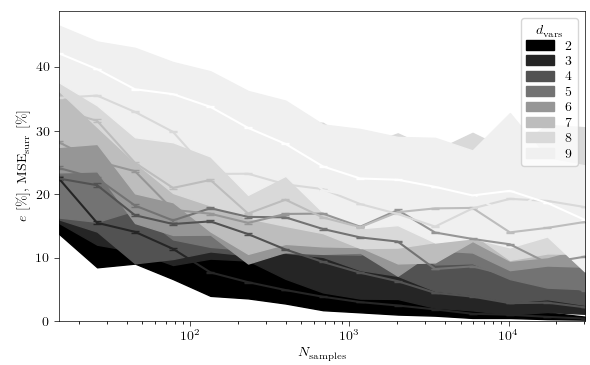

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
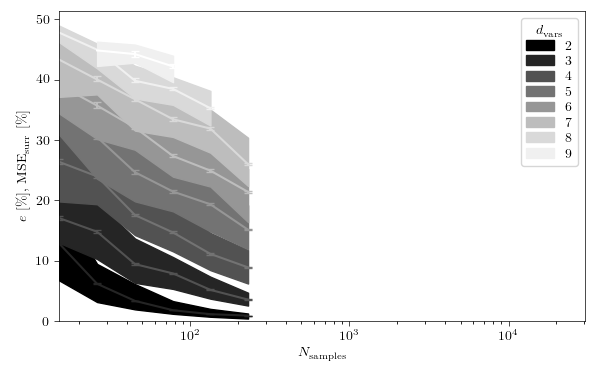

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
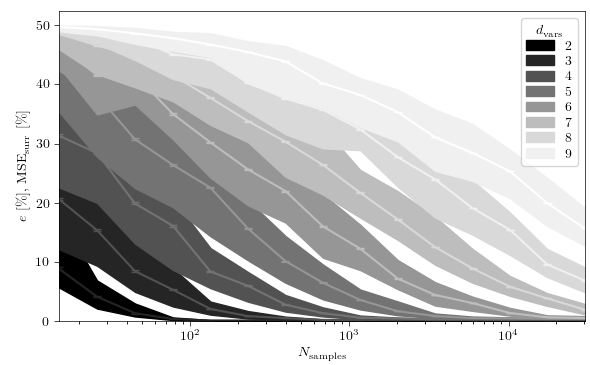

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
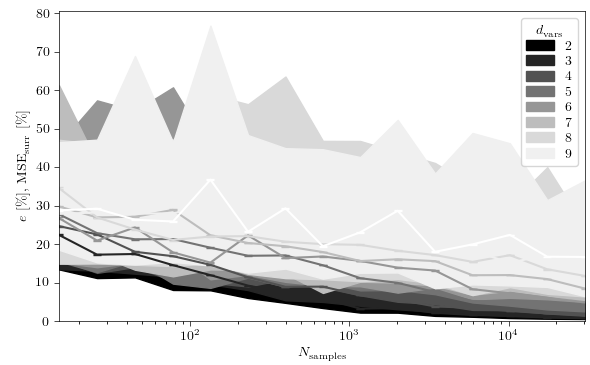

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
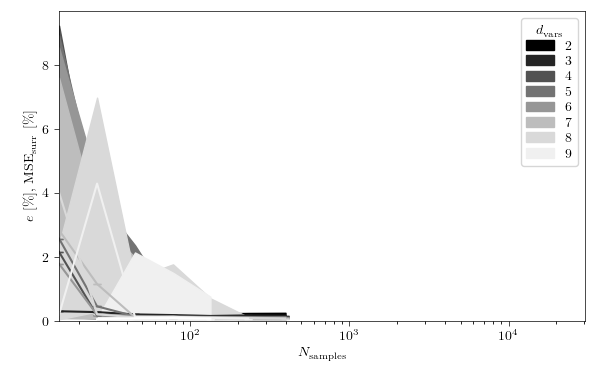

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
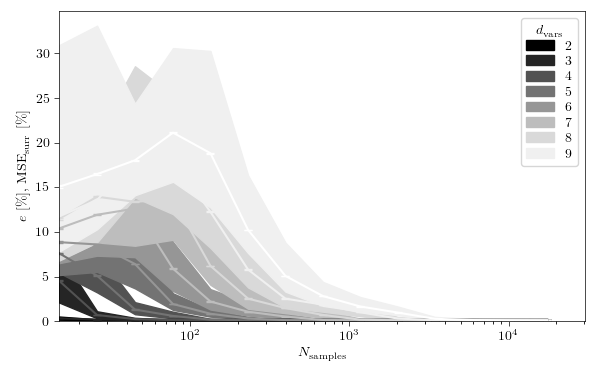

In [5]:
for im in range(2):
    for ii in range(3):
        # im=0
        # ii=2
        map_ = ['psin','rod'][im]
        intp = ['nearest','linear','rbf'][ii]
        in_dict = np.load(f'/usr/scratch4/sima9999/work/modal_uq/convergence_iv_opt_{map_}_{intp}.npz')
        N_vars = in_dict['N_vars']
        tot_errs = in_dict['tot_errs']*50
        intp_errs = in_dict['intp_errs']
        N_mcs = in_dict['N_mcs']
        N_mcs = N_mcs[N_mcs<50000]
        vol_fracs = in_dict['vol_fracs']

        tot_intervals = np.zeros((len(N_vars),N_mcs.shape[0],3))
        intp_intervals = np.zeros((len(N_vars),N_mcs.shape[0],3))
        with matplotlib.rc_context(get_pcd()):
            plt.figure()
            colors=['#ffffff', '#f0f0f0', '#d9d9d9', '#bdbdbd', '#969696', '#737373', '#525252', '#252525', '#000000']
            colors.reverse()
            for i,nvars in enumerate(N_vars):
            #     if nvars<5: continue
            #     print(f'nvars={nvars}')
                for errs, intervs in ((tot_errs, tot_intervals),(intp_errs, intp_intervals)):
                    for j, n_mcs in enumerate(N_mcs):
                #         print(f'N_mcs = {int(basis**nvars)}')

                        this_errs = errs[i,j,:]
                        this_errs[this_errs==0] = np.nan
                        this_errs = this_errs[~np.isnan(this_errs)]
                        if len(this_errs) > 2:
            #                 print(len(errs))
            #             errs = intp_errs[i,j,:]
                #         print(errs)
            #                 l,u = scipy.stats.t.interval(alpha=0.95, df=len(errs)-1, loc=np.mean(errs), scale=scipy.stats.sem(errs)) 
                            l,m,u = np.percentile(this_errs,(25,50,75))
                        else:
                            l,m,u = np.nan,np.nan,np.nan
                        intervs[i,j,:] = [l,m,u]

            #         print(l,u)
            #     print(intervals[i,:,:])
                coll = plt.fill_between(N_mcs,tot_intervals[i,:,0],tot_intervals[i,:,2], color=colors[i], label=f'{nvars}')

                plt.errorbar(N_mcs, tot_intervals[i,:,1], yerr=intp_intervals[i,:,(0,2)], 
                             #color=coll.get_facecolor()[0], 
                             color=colors[i+1],
                             capsize=3.0)
            plt.xscale('log')
            # plt.yscale('log')
            plt.ylim(ymin=0)
            plt.xlim((N_mcs[1], N_mcs.max()))
            plt.ylabel("$e$ [\si{\percent}], $\mathrm{MSE}_\mathrm{surr}$ [\si{\percent}]")
            plt.xlabel("$N_\mathrm{samples}$")
            plt.legend(title='$d_\mathrm{vars}$')
            plt.subplots_adjust(top=0.97,bottom=0.12, left=0.1, right=0.99)
            plt.savefig(f'/usr/scratch4/sima9999/work/2019_OMA_UQ/tex/figures/uncertainty/convergence_iv_opt_{map_}_{intp}.png')
            plt.savefig(f'/usr/scratch4/sima9999/work/2019_OMA_UQ/tex/figures/uncertainty/convergence_iv_opt_{map_}_{intp}.pdf')
            plt.show()

In [69]:
coll.get_facecolor()[0]

array([0.49803922, 0.49803922, 0.49803922, 0.5       ])

In [5]:
'''
- try linear interpolator
- try rbf interpolator
- try other objective

'''
N_runs = 1000
N_vars = np.arange(2,10)
errors_rand = np.zeros((len(N_vars),N_runs))
N_mcss = np.random.randint(3**3,4**9, N_runs)
hyc_vol_frac = np.random.random(N_runs)

In [ ]:
ray.init(address='auto', _redis_password='5241590000000000')
futures = []

@ray.remote
def sub(i,j,nvars,n_mcs,hyc_vol_frac):
    try:
        err, vol_frac = error_fun(nvars, n_mcs, np.power(hyc_vol_frac,nvars))
    except Exception as e:
        print(e)
        err = np.nan
    return i,j,err

for i,nvars in enumerate(N_vars):
    print(i)
    for j in range(N_runs):
        if not j%100: print(j)
#         if errors_rand[i,j] != 0: continue
#         errors_rand[i,j] = error_fun(nvars, N_mcss[j],hyc_vol_frac[j])[0]

        futures.append(sub.remote(i,j,nvars,N_mcss[j],hyc_vol_frac[j]))
            
futures = set(futures)
while True:
    ready, wait = ray.wait(list(futures), num_returns=min(len(futures), 100), timeout=180)
    
    try:
        ret_sets = ray.get(ready)
        for i,j,err in ret_sets:
            errors_rand[i,j] = err
        size_before = len(futures)
        futures.difference_update(ready)
        print(f"Finished {len(ready)} samples. Remaining {len(futures)} samples. (before {size_before})")
    except:
        pass
    if len(futures) == 0:
        break
np.savez('/usr/scratch4/sima9999/work/modal_uq/iv_opt_error_vs_hyc_vol_frac.npz',**{'N_vars':N_vars,'errors_rand':errors_rand,'N_mcss':N_mcss,'hyc_vol_frac':hyc_vol_frac})    

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
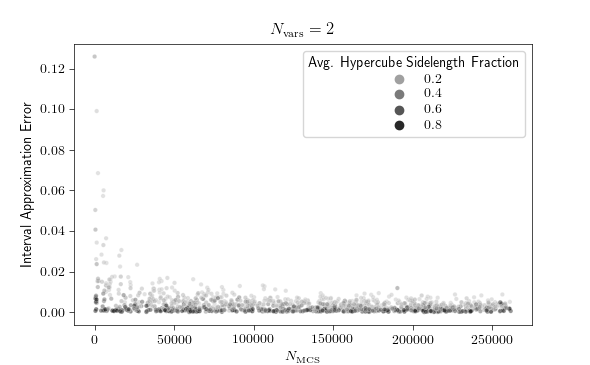

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
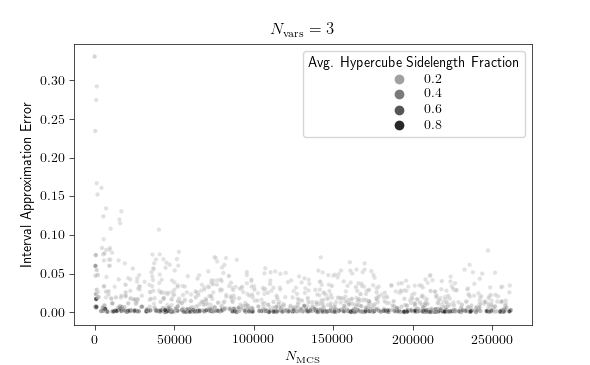

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
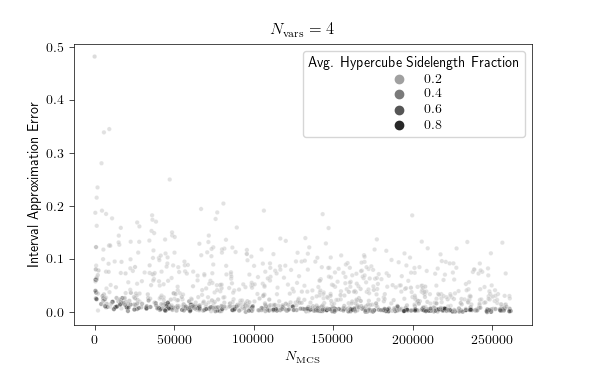

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
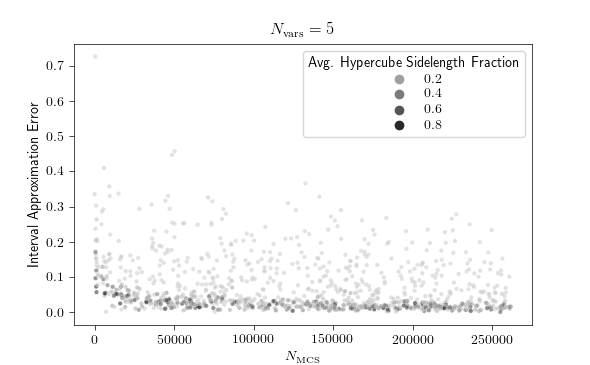

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
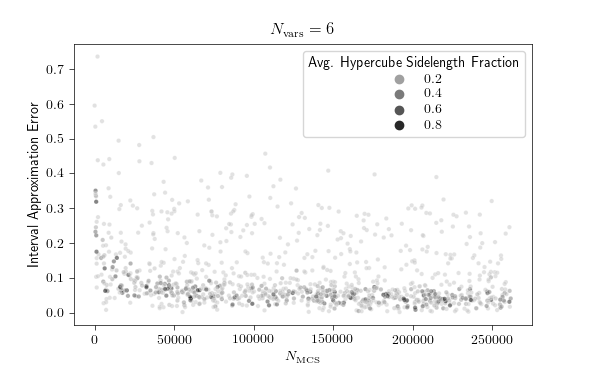

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
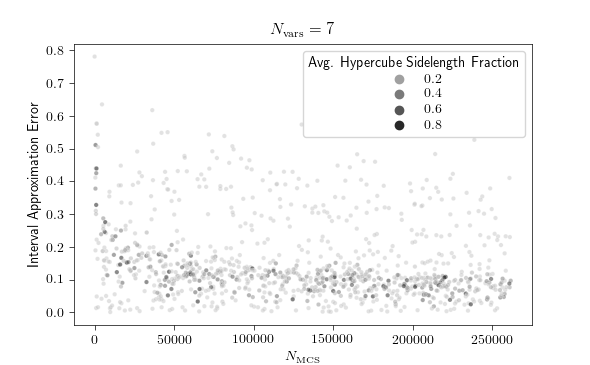

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
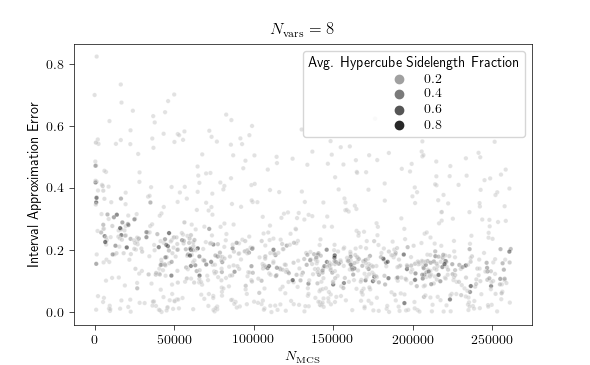

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
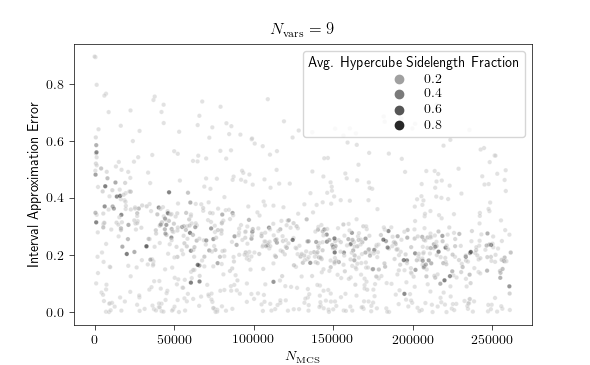

In [21]:
from helpers import get_pcd
plt.close('all')
# from mpl_toolkits.mplot3d import Axes3D
for i,nvars in enumerate(N_vars):
    with matplotlib.rc_context(get_pcd()):
        fig = plt.figure()
    #     ax = fig.add_subplot(111, projection='3d')
    #     ax.plot(xs=N_mcss,ys=hyc_vol_frac,zs=errors_rand[i,:], ls='none', marker=',')

    #     ax.set_zlim((0,0.1))
    #     ax.set_zscale('log')
        sns.scatterplot(x=N_mcss,hue=np.power(hyc_vol_frac,nvars), y=errors_rand[i,:], alpha=0.5, palette='Greys', s=10,hue_norm=(-0.5,1))
        ax = plt.gca()
        ax.legend().set_title('Avg. Hypercube Sidelength Fraction')
    #     ax.set_xscale('log')
    #     ax.set_yscale('log')
        ax.set_xlabel("$N_\mathrm{MCS}$")
        ax.set_ylabel('Interval Approximation Error')
        ax.set_title(f'$N_\mathrm{{vars}} = {nvars}$')
    #     plt.gca().set_ylim((0,1))
#         ax.grid(which='both',axis='y')
        plt.savefig(f'/usr/scratch4/sima9999/work/2019_OMA_UQ/tex/figures/uncertainty/iv_opt_{nvars}_error_vs_hyc_vol_frac.png')
        plt.savefig(f'/usr/scratch4/sima9999/work/2019_OMA_UQ/tex/figures/uncertainty/iv_opt_{nvars}_error_vs_hyc_vol_frac.pdf')

continue

✔️ example with scatterplot matrices showing the behavior of different interpolators (e.g. nearestND: creating band structures, RBF: over/undershooting, wavy behavior; LinearND: not building on nvar>9) on the prod(sin) test function

✔️ show error coming mostly from undersampling, 

✔️ show example with higher dimension

✔️ show example with easier test function, where everything works much betters

✔️ show convergence study for all nvars over the same N_mcs range with higher N_runs for both objectives

✔️ show hypercube volume fraction has little effect on results

tune RBF interpolator / set epsilon parameter
how to distinguish sampling and interpolation error?


In [221]:
import matplotlib.tri
N=5
NMCS=1000000
xi = np.random.random((NMCS,N))
y = np.product(np.sin(np.pi*xi),axis=1)
display(np.sum(y>0.99)/NMCS)
# triang = matplotlib.tri.Triangulation(xi[:,0],xi[:,1])
# plt.figure()
# plt.tricontourf(triang, y)
# plt.show()

0.0